# Multi-Resolution Modeling

This tutorial shows how to model sources frome images observed with different telescopes. We will use a multiband observation with the Hyper-Sprime Cam (HSC) and a single high-resolution image from the Hubble Space Telescope (HST).

In [1]:
# Import Packages and setup
import numpy as np
import scarlet
import scarlet.display
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from scarlet import Starlet
from scarlet.wavelet import mad_wavelet
import scipy.stats as scs

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')

## Load and Display Data

We first load the HSC and HST images, swapping the byte order if necessary because a bug in astropy does not respect the local endianness.

In [26]:
coords = ((150.2311511, 2.0725000),
(150.23575, 2.0736144),
(150.2407120, 2.06514),
(150.2537000, 2.0480000),
(150.3054000, 2.0823254),
(150.3305180, 2.0707583))

# Load HST psf
psf_hst = fits.open('./data/PSF_HST.fits')[0].data
psf_hst = psf_hst[None,:,:]
psf_hst = scarlet.PSF(psf_hst)

coord = coords[2]
# Load HSC data
obs_hdu = fits.open(f'data/hsc_ra={coord[0]:.5f}_dec={coord[1]:.5f}.fits')
data_hsc = obs_hdu[0].data.byteswap().newbyteorder()
wcs_hsc = WCS(obs_hdu[0].header)

# Load HST data
obs_hdu = fits.open(f'data/hst_ra={coord[0]:.5f}_dec={coord[1]:.5f}.fits')
data_hst = obs_hdu[0].data.byteswap().newbyteorder()[None,:,:]
wcs_hst = WCS(obs_hdu[0].header)

# Load HSC psf
psf_hsc = fits.open(f'data/psf_hsc_ra={coord[0]:.5f}_dec={coord[1]:.5f}.fits')[0].data
psf_hsc = scarlet.PSF(psf_hsc)

# Channels
channels_hst = ['F814w']
channels_hsc = ['g','r','i','z','y']

# Scale the HST data
_,n1,n2 = np.shape(data_hst)
data_hst = data_hst.reshape(1, n1, n2).byteswap().newbyteorder()
# Scale the HSC data
r, N1, N2 = data_hsc.shape

Next we have to create a source catalog for the images. We'll use `sep` for that, but any other detection method will do. Since HST is higher resolution and less affected by blending, we use it for detection but we also run detection on the HSC image to calculate the background RMS:

In [27]:
import sep

class Data():
    
    def __init__(self, images, wcss, psfs, channels):
        self.images = images
        self.wcs = wcss
        self.psfs = psfs.image
        self.channels = channels

def interpolate(data_lr, data_hr):
    #Interpolate low resolution data to high resolution
    coord_lr0 = (np.arange(data_lr.images.shape[1]), np.arange(data_lr.images.shape[1]))
    coord_hr = (np.arange(data_hr.images.shape[1]), np.arange(data_hr.images.shape[1]))
    coord_lr = scarlet.resampling.convert_coordinates(coord_lr0, data_lr.wcs, data_hr.wcs)
    
    interp = []
    for image in data_lr.images:
        interp.append(scarlet.interpolation.sinc_interp(image[None, :,:], coord_hr, coord_lr, angle=None)[0].T)
    return np.array(interp)
        
def makeCatalog_multi(data_lr, data_hr, lvl = 3, wave = True):
    #Create observations for each image
    #Interpolate low resolution to high resolution
    interp = interpolate(data_lr, data_hr)
    #Normalisation of the interpolate low res images
    interp = interp/np.sum(interp, axis = (1,2))[:,None, None]
    #Normalisation of the high res data
    hr_images = data_hr.images/np.sum(data_hr.images, axis = (1,2))[:,None, None]
    #Detection image as the sum over all images
    detect_image = np.sum(interp, axis = 0) + np.sum(hr_images, axis = 0)
    detect_image *= np.sum(data_hr.images)
    if np.size(detect_image.shape) == 3:
        if wave:
            #Wavelet detection in the first three levels
            wave_detect = Starlet(detect_image.mean(axis=0), lvl = 4).coefficients
            wave_detect[:,-1,:,:] = 0
            detect = Starlet(coefficients = wave_detect).image
        else:
            #Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = Starlet(detect_image).coefficients
            detect = wave_detect[0][0] + wave_detect[0][1] +  wave_detect[0][2] 
        else:
            detect = detect_image
    

    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)
    bg_rms = []
    for data in datas:
        bg_rms.append(mad_wavelet(data.images))
 
    return catalog, bg_rms, detect_image

def makeCatalog(data, lvl = 3, wave = True):
    #Normalisation of the data
    hr_images = data/np.sum(data, axis = (1,2))[:,None, None]
    #Detection image as the sum over all images
    detect_image = np.sum(hr_images, axis = 0)
    
    if np.size(detect_image.shape) == 3:
        if wave:
            #Wavelet detection in the first three levels
            wave_detect = Starlet(detect_image.mean(axis=0), lvl = 4).coefficients
            wave_detect[:,-1,:,:] = 0
            detect = Starlet(coefficients = wave_detect).image
        else:
            #Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = Starlet(detect_image).coefficients
            detect = wave_detect[0][0] + wave_detect[0][1] +  wave_detect[0][2] 
        else:
            detect = detect_image
    

    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)
    bg_rms = mad_wavelet(data)

    return catalog, bg_rms, detect_image

In [28]:
data_hr =  Data(data_hst, wcs_hst, psf_hst, channels_hst)
data_lr =  Data(data_hsc, wcs_hsc, psf_hsc, channels_hsc)
datas = [data_lr, data_hr]

wave = 1
lvl = 3
catalog_multi, bg_rms_multi, detect_multi = makeCatalog_multi(data_lr, data_hr, lvl, wave)

catalog_hsc, bg_rms_hsc, detect_hsc = makeCatalog(data_hsc, lvl, wave)
catalog_hst, bg_rms_hst, detect_hst = makeCatalog(data_hst, lvl, wave)

weights_hst = np.ones_like(data_hst) / (bg_rms_multi[1]**2)[:, None, None]
weights_hsc = np.ones_like(data_hsc) / (bg_rms_multi[0]**2)[:, None, None]

Finally we can visualize both the multiband HSC and single band HST images in their native resolutions:

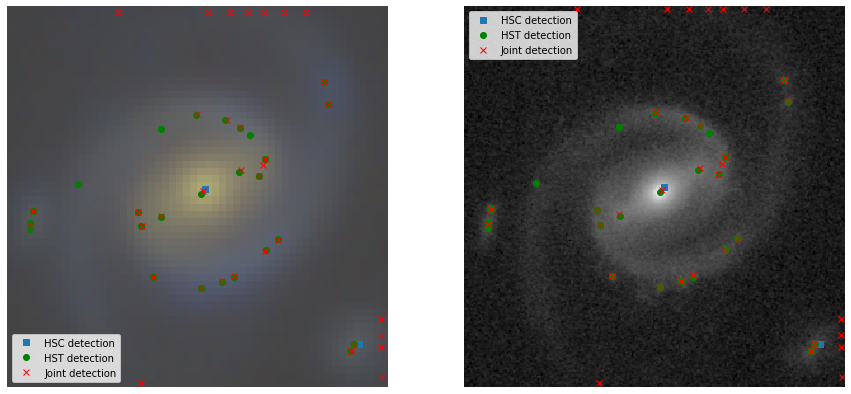

In [29]:
# Create a color mapping for the HSC image
hsc_norm = AsinhMapping(minimum=-1, stretch=2, Q=10)
hst_norm = AsinhMapping(minimum=-1, stretch=10, Q=5)

# Get the source coordinates from the HST catalog
xt,yt = catalog_hst['x'], catalog_hst['y']
xm,ym = catalog_multi['x'], catalog_multi['y']
xc,yc = catalog_hsc['x'], catalog_hsc['y']
# Convert the HST coordinates to the HSC WCS
rat, dect = wcs_hst.wcs_pix2world(yt,xt,0)
ram, decm = wcs_hst.wcs_pix2world(ym,xm,0)
rac, decc, _ = wcs_hsc.wcs_pix2world(yc,xc,0, 0)

Yt,Xt, l = wcs_hsc.wcs_world2pix(rat, dect, 0, 0)
Ym,Xm, l = wcs_hsc.wcs_world2pix(ram, decm, 0, 0)
Yc,Xc = wcs_hst.wcs_world2pix(rac, decc, 0)
# Map the HSC image to RGB
img_rgb = scarlet.display.img_to_rgb(data_hsc, norm=hsc_norm)
# Apply Asinh to the HST data
hst_img = scarlet.display.img_to_rgb(data_hst, norm=hst_norm)

plt.figure(figsize=(15,30))
plt.subplot(121)
plt.imshow(img_rgb)
plt.axis('off')
plt.plot(xc,yc, 's', label = 'HSC detection')
plt.plot(Xt,Yt, 'og', label = 'HST detection')
plt.plot(Xm,Ym, 'xr', label = 'Joint detection')
plt.legend()

plt.subplot(122)
plt.imshow(hst_img)
plt.axis('off')
plt.plot(Xc,Yc, 's', label = 'HSC detection')
plt.plot(xt,yt, 'og', label = 'HST detection')
plt.plot(xm,ym, 'xr', label = 'Joint detection')
plt.legend()
plt.show()

## Create Frame and Observations

Unlike the single resolution examples, we now have two different instruments with different pixel resolutions, so we need two different observations. Since the HST image is at a much higher resolution, we define our model `Frame` to use the HST PSF and the HST resolution. Because there is no resampling between the model frame and the HST observation, we can use the default `Observation` class for the HST data. The HSC images have lower resolution, so we need to resample the models to this frame, and that's done by `LowResObservation`.

Alternatively, it is possible to define a frame automatically from a set of observations. In this case, the user does not have to know which observation needs to be a `LowResObservation`. Instead, method `frome_observation` creates a frame that encapsluates, either the union or the intersection of a set of observations, and defines a frame based on the highest resolution available between all observations.

In [30]:
#Automated frame definition
# define two observation packages and match to frame
multi_hst = scarlet.Observation(data_hst, wcs=wcs_hst, psfs=psf_hst, channels=channels_hst, weights=weights_hst)
multi_hsc = scarlet.Observation(data_hsc, wcs=wcs_hsc, psfs=psf_hsc, channels=channels_hsc, weights=weights_hsc)

# Keep the order of the observations consistent with the `channels` parameter
# This implementation is a bit of a hack and will be refined in the future
obs = [multi_hsc, multi_hst]
frame = scarlet.Frame.from_observations(obs, coverage = 'intersection')
multi_hsc, multi_hst = obs

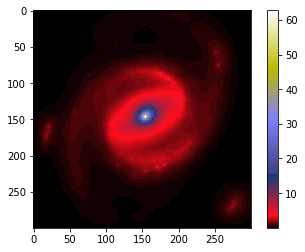

In [31]:
#Detection for multi resolution
det_lr = scarlet.Starlet(data_lr.images).filter(k = 10)
det_lr /= det_lr.sum()
det_hr = scarlet.Starlet(data_hr.images).filter(k = 10)
det_hr /= det_hr.sum()

detect_hr =  Data(det_hr, wcs_hst, psf_hst, channels_hst)
detect_lr =  Data(det_lr, wcs_hsc, psf_hsc, channels_hsc)

detect_image = interpolate(detect_lr, detect_hr).max(axis = 0)[None,:,:]/10
detect_image += detect_hr.images/2
detect_image *= np.sum(data_hst)/np.sum(detect_image)

weights_detect = np.ones_like(data_hst) / (mad_wavelet(detect_image)**2)[:, None, None]
plt.imshow(detect_image[0])
plt.colorbar()
plt.show()
obs_detect = scarlet.Observation(detect_image, wcs=wcs_hst, psfs=psf_hst, channels=channels_hst, weights = weights_detect)
obs_detects = [multi_hsc, obs_detect]
frame_detect = scarlet.Frame.from_observations(obs_detects, coverage = 'intersection')
obs_detect = obs_detects[1]

In this experiment, we are going to compare the fit to the data using HSC data alone, HST data alone and the multi-reolution framework applied to the combination of HST and HSC. We need to build a frame for each of these cases:

In [32]:
obs_hst = scarlet.Observation(data_hst, wcs=wcs_hst, psfs=psf_hst, channels=channels_hst, weights=weights_hst)
obs_hsc = scarlet.Observation(data_hsc, wcs=wcs_hsc, psfs=psf_hsc, channels=channels_hsc, weights=weights_hsc)

HSC_frame = scarlet.Frame(
    data_hsc.shape,
    wcs = wcs_hsc,
    psfs=psf_hsc,
    channels=channels_hsc)
obs_hsc.match(HSC_frame)

HST_frame = scarlet.Frame(
    data_hst.shape,
    wcs = wcs_hst,
    psfs=psf_hst,
    channels=channels_hst)
obs_hst.match(HST_frame)


## Initialize Sources and Blend

We expect all sources to be galaxies, so we initialized them as `ExtendedSources`. Because the initialization takes a list of observations, we set the `obs_idx` argument to state which observation in the list of observations is used to initialize the morphology.

`Blend` will hold a list of all sources and *all* observations to fit.

In [33]:
#Detection with multiple observations
multi_sources = [
    scarlet.ExtendedSource(frame_detect, (ram[i], decm[i]), obs_detects, 
                           symmetric=False, 
                           monotonic=True, 
                           obs_idx=1,
                           min_grad = 0)
    for i in range(ram.size)
]

blend_multi = scarlet.Blend(multi_sources, obs)

In [34]:
#Detection HSC only
HSC_sources = [
    scarlet.ExtendedSource(HSC_frame, (rac[i], decc[i]), obs_hsc, 
                           symmetric=False, 
                           monotonic=True)
    for i in range(rac.size)
]

blend_hsc = scarlet.Blend(HSC_sources, obs_hsc)

In [35]:
#Detection HST only
HST_sources = [
    scarlet.ExtendedSource(HST_frame, (rat[i], dect[i]), obs_hst, 
                           symmetric=False, 
                           monotonic=True,
                           min_grad = 0)
    for i in range(rat.size)
]

blend_hst = scarlet.Blend(HST_sources, obs_hst)

In [36]:
#Detection HSC only from multi catalog
HSC_sources = [
    scarlet.ExtendedSource(HSC_frame, (ram[i], decm[i]), obs_hsc, 
                           symmetric=False, 
                           monotonic=True)
    for i in range(ram.size)
]

blend_multihsc = scarlet.Blend(HSC_sources, obs_hsc)

In [37]:
#Detection HST only from multi catalog
HST_sources = [
    scarlet.ExtendedSource(HST_frame, (ram[i], decm[i]), obs_hst, 
                           symmetric=False, 
                           monotonic=True,
                           min_grad = 0)
    for i in range(ram.size)
]

blend_multihst = scarlet.Blend(HST_sources, obs_hst)

Zero or negative SED [-0.13317132] at y=150.23979814226365, x=2.0663713316384156
/Users/remy/Desktop/LSST_Project/scarlet/scarlet/source.py:126: RuntimeWarning: invalid value encountered in double_scalars
  weights = np.array([sed[c] / bg_rms[c] ** 2 for c in positive])
/Users/remy/Desktop/LSST_Project/scarlet/scarlet/source.py:129: RuntimeWarning: invalid value encountered in double_scalars
  


ValueError: not enough values to unpack (expected 2, got 0)

## Display Initial guess

Let's compare the initial guess of the model in both model frame and HSC observation frame:

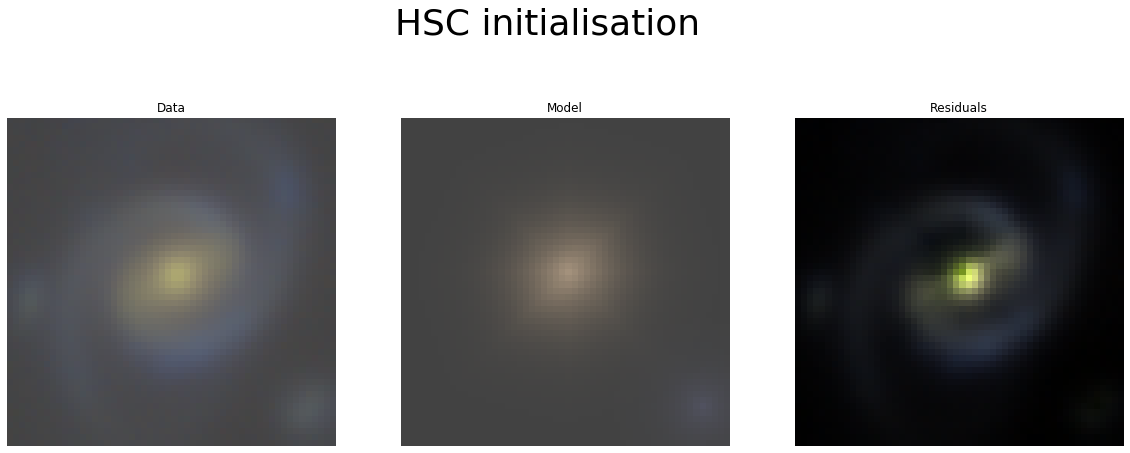

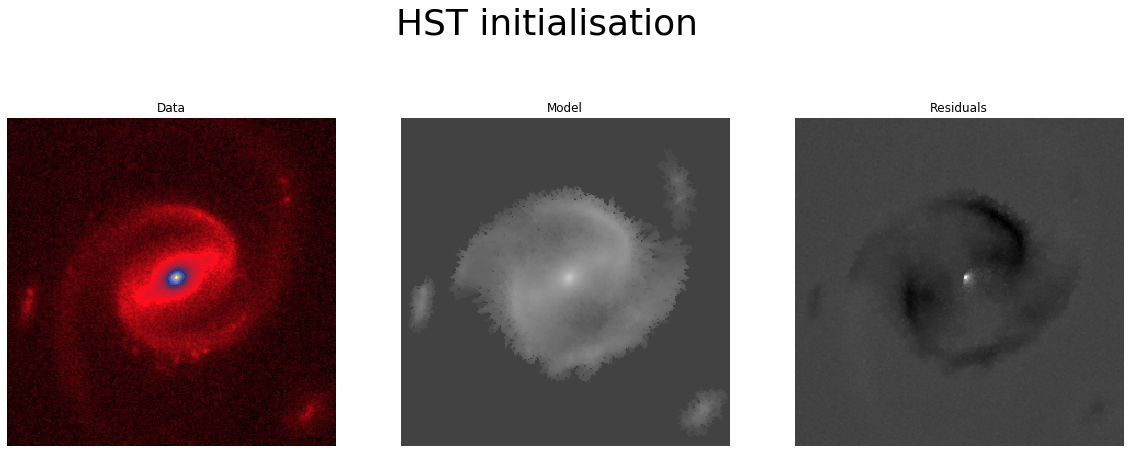

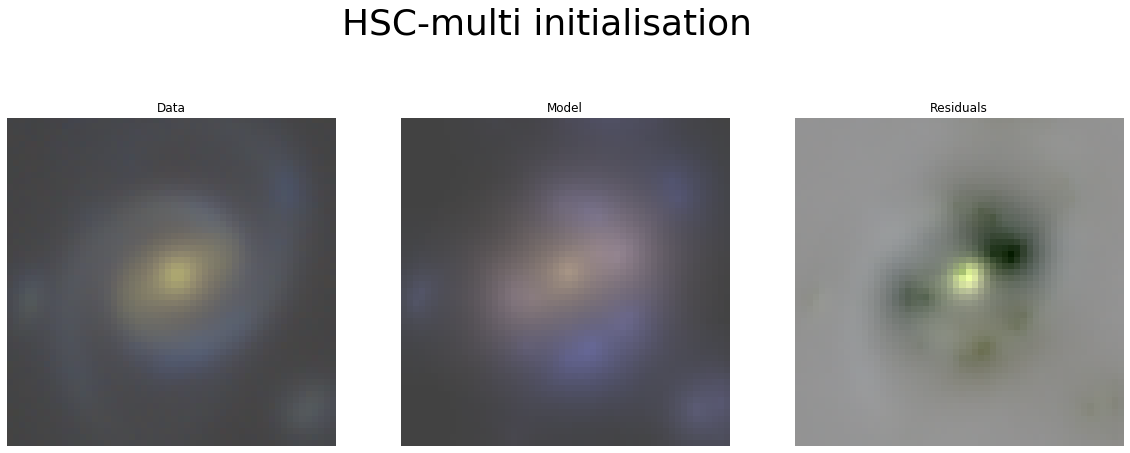

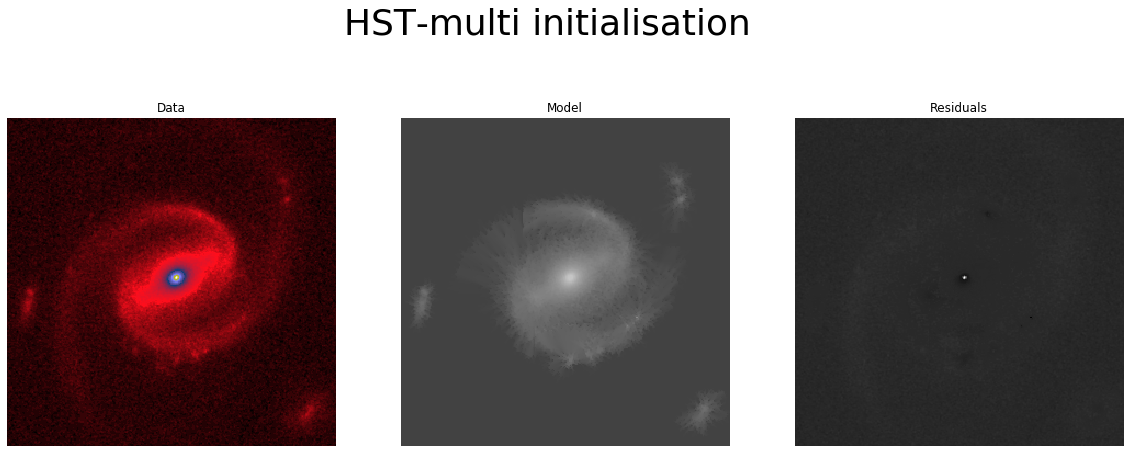

In [38]:
def display_init(blend, obs, data, ids, img, title):
    # Load the model and calculate the residual
    model = blend.get_model()
    model = obs.render(model)
    
    init_rgb = scarlet.display.img_to_rgb(model, norm=hsc_norm)
    residual = data - model
    
    residual_rgb = scarlet.display.img_to_rgb(residual[:,:])
    vmax = np.max(np.abs(residual_rgb))
    if residual_rgb.shape[0]<2:
        residual_rgb = residual_rgb[0,:,:]
        print('zizi')
    plt.figure(ids,figsize=(20, 8))
    plt.suptitle(title, fontsize=36)
    plt.subplot(131)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Data")
    plt.subplot(132)
    plt.imshow(init_rgb)
    plt.axis('off')
    plt.title("Model")
    plt.subplot(133)
    plt.imshow(residual_rgb, vmin=-vmax, vmax=vmax, cmap = 'seismic')
    plt.axis('off')
    plt.title("Residuals")
    pass

display_init(blend_hsc, obs_hsc, data_hsc, 0, img_rgb, 'HSC initialisation')
display_init(blend_hst, obs_hst, data_hst, 1, data_hst[0], 'HST initialisation')
display_init(blend_multihsc, obs_hsc, data_hsc, 2, img_rgb, 'HSC-multi initialisation')
display_init(blend_multihst, obs_hst, data_hst, 3, data_hst[0], 'HST-multi initialisation')

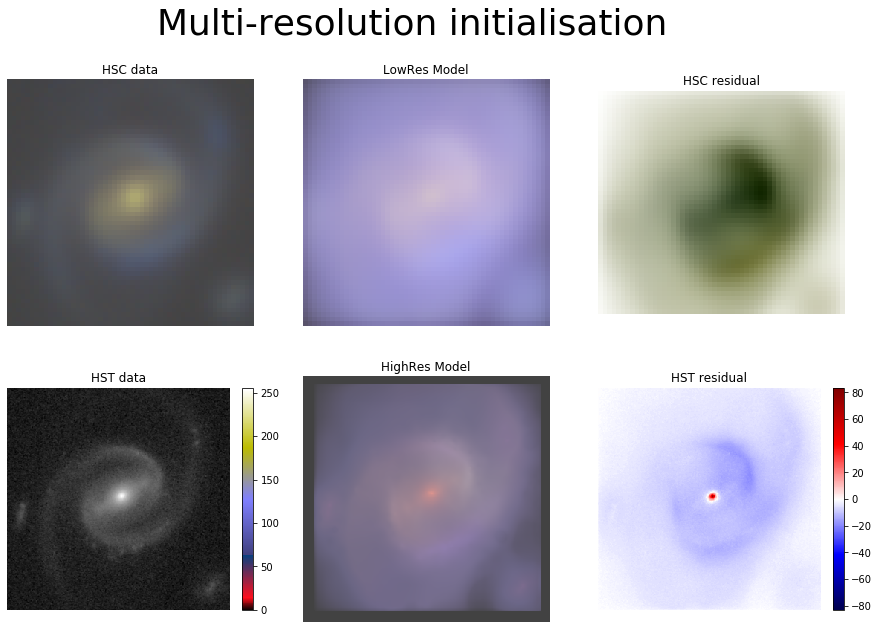

In [39]:
# Load the model and calculate the residual
model_multi = blend_multi.get_model()

model_lr = multi_hsc.render(model_multi)
init_rgb = scarlet.display.img_to_rgb(model_multi, norm=hsc_norm)
init_rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=hsc_norm)
residual_lr = data_hsc - model_lr
# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:-5])

# Get the HR residual
residual_hr = (data_hst - multi_hst.render(model_multi))[0]
vmax = residual_hr.max()

plt.figure(figsize=(15, 10))

plt.subplot(231)
plt.suptitle('Multi-resolution initialisation', fontsize=36)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("HSC data")
plt.subplot(235)
plt.imshow(init_rgb)
plt.axis('off')
plt.title("HighRes Model")
plt.subplot(232)
plt.imshow(init_rgb_lr)
plt.axis('off')
plt.title("LowRes Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.axis('off')
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.axis('off')
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hst_img)
plt.axis('off')
plt.colorbar(fraction=.045)
plt.title('HST data')
plt.show()

## Fit Models

scarlet ran for 100 iterations to logL = -57086.63986342054


Text(0, 0.5, 'log-Likelihood')

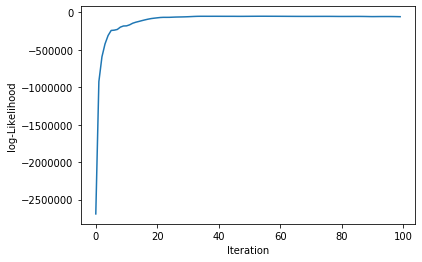

In [40]:
blend_hst.fit(100, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_hst.loss), -blend_hst.loss[-1]))
plt.plot(-np.array(blend_hst.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

scarlet ran for 100 iterations to logL = -83443.51834537412


Text(0, 0.5, 'log-Likelihood')

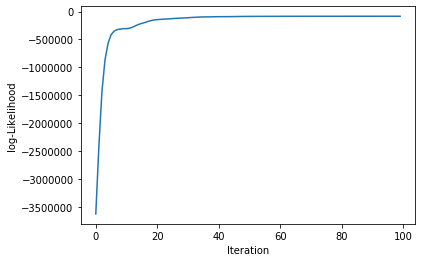

In [41]:
blend_hsc.fit(100, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_hsc.loss), -blend_hsc.loss[-1]))
plt.plot(-np.array(blend_hsc.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

scarlet ran for 200 iterations to logL = -109325.10080092054


Text(0, 0.5, 'log-Likelihood')

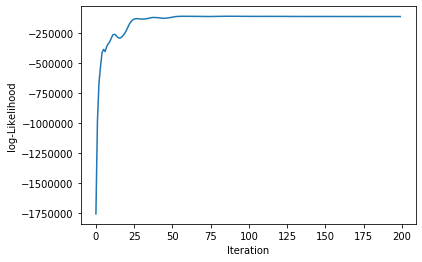

In [42]:
blend_multihst.fit(100, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_multihst.loss), -blend_multihst.loss[-1]))
plt.plot(-np.array(blend_multihst.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

scarlet ran for 100 iterations to logL = 28990.753139000873


Text(0, 0.5, 'log-Likelihood')

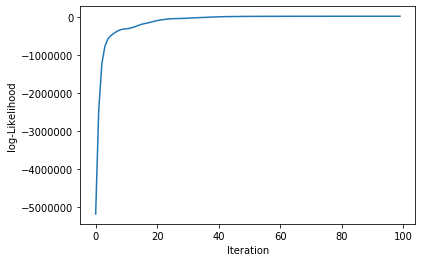

In [43]:
blend_multihsc.fit(100, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_multihsc.loss), -blend_multihsc.loss[-1]))
plt.plot(-np.array(blend_multihsc.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

CPU times: user 2h 2min 50s, sys: 42min 17s, total: 2h 45min 7s
Wall time: 2h 28min 49s
scarlet ran for 300 iterations to logL = -285200.39642053697


Text(0, 0.5, 'log-Likelihood')

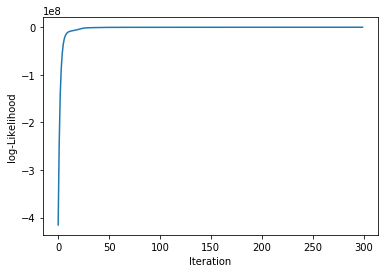

In [20]:
%time blend_multi.fit(300, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_multi.loss), -blend_multi.loss[-1]))
plt.plot(-np.array(blend_multi.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

### View Full Model
First we load the model for the entire blend and its residual. Then we display the model using the same $sinh^{-1}$ stretch as the full image and a linear stretch for the residual to see the improvement from our initial guess.

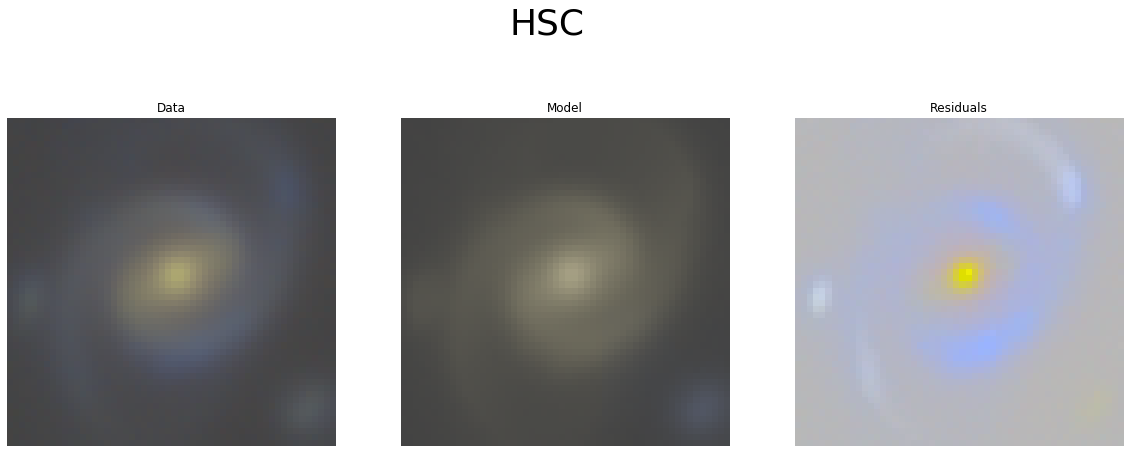

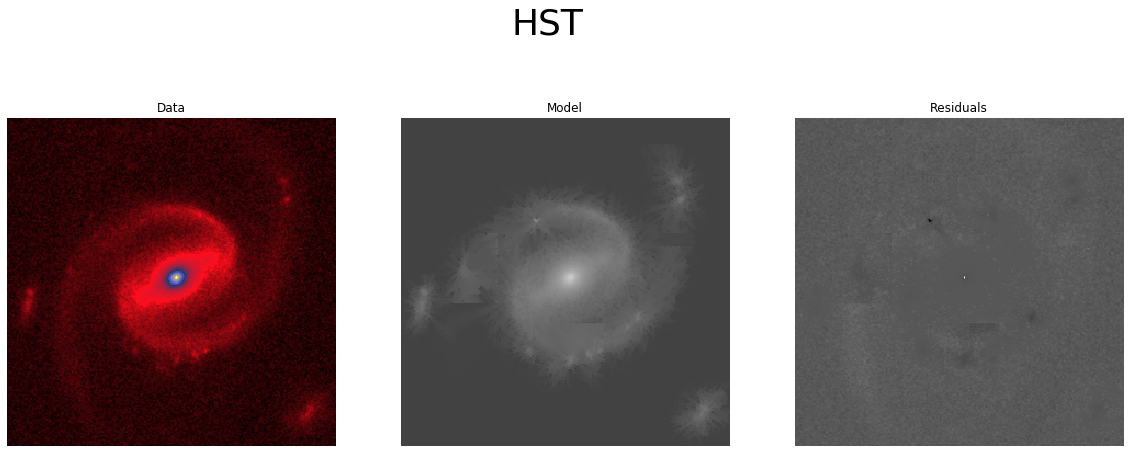

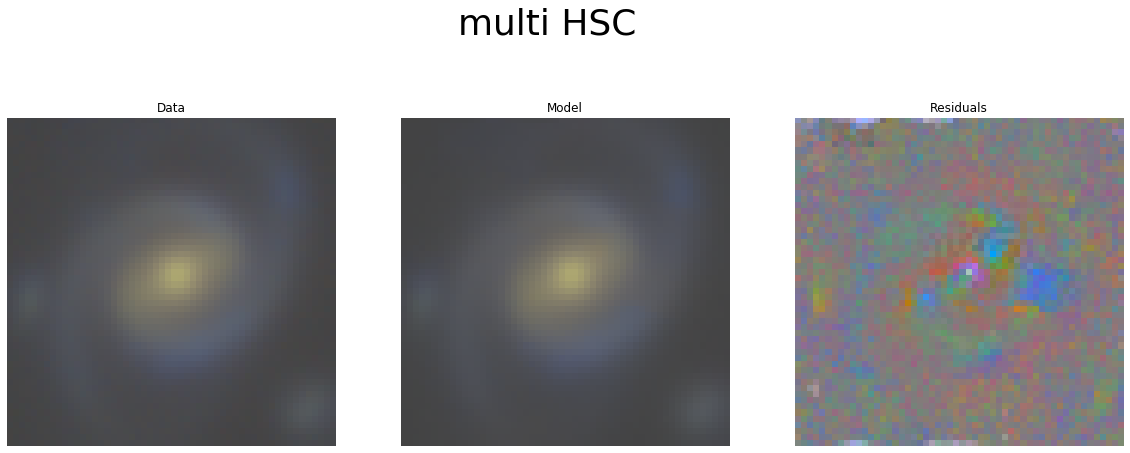

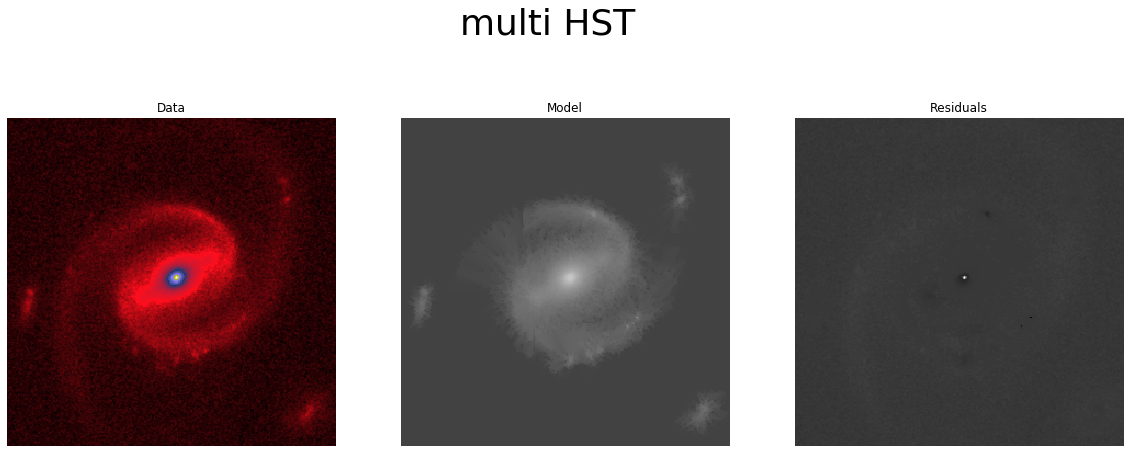

In [44]:
display_init(blend_hsc, obs_hsc, data_hsc, 0, img_rgb, 'HSC')
display_init(blend_hst, obs_hst, data_hst, 1, data_hst[0], 'HST')
display_init(blend_multihsc, obs_hsc, data_hsc, 2, img_rgb, 'multi HSC')
display_init(blend_multihst, obs_hst, data_hst, 3, data_hst[0], 'multi HST')

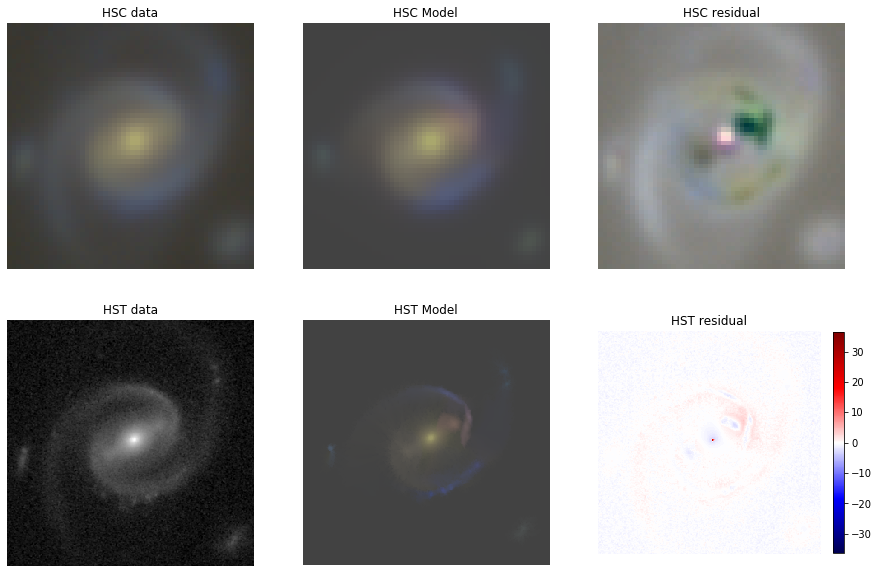

In [22]:
model_multi = blend_multi.get_model()
model_hr = multi_hst.render(model_multi)
model_lr = multi_hsc.render(model_multi)

rgb = scarlet.display.img_to_rgb(model_multi[:-1], norm=hsc_norm)
rgb_lr = scarlet.display.img_to_rgb(model_lr, norm=hsc_norm)
residual_lr = data_hsc - model_lr

# Trim the bottom source not part of the blend from the image
residual_lr_rgb = scarlet.display.img_to_rgb(residual_lr[:,:])

# Get the HR residual
residual_hr = (data_hst - model_hr)[0]
vmax = residual_hr.max()

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.imshow(img_rgb)
plt.axis('off')
plt.title("HSC data")
plt.subplot(235)
plt.imshow(rgb)
plt.axis('off')
plt.title("HST Model")
plt.subplot(232)
plt.imshow(rgb_lr)
plt.axis('off')
plt.title("HSC Model")
plt.subplot(236)
plt.imshow(residual_hr, cmap="seismic", vmin=-vmax, vmax=vmax)
plt.axis('off')
plt.colorbar(fraction=.045)
plt.title("HST residual")
plt.subplot(233)
plt.imshow(residual_lr_rgb)
plt.axis('off')
plt.title("HSC residual")
plt.subplot(234)
plt.imshow(hst_img)
plt.axis('off')
plt.title('HST data')
plt.show()

### View Source Models
It can also be useful to view the model for each source. For each source we extract the portion of the image contained in the sources bounding box, the true simulated source flux, and the model of the source, scaled so that all of the images have roughly the same pixel scale.

source number  0


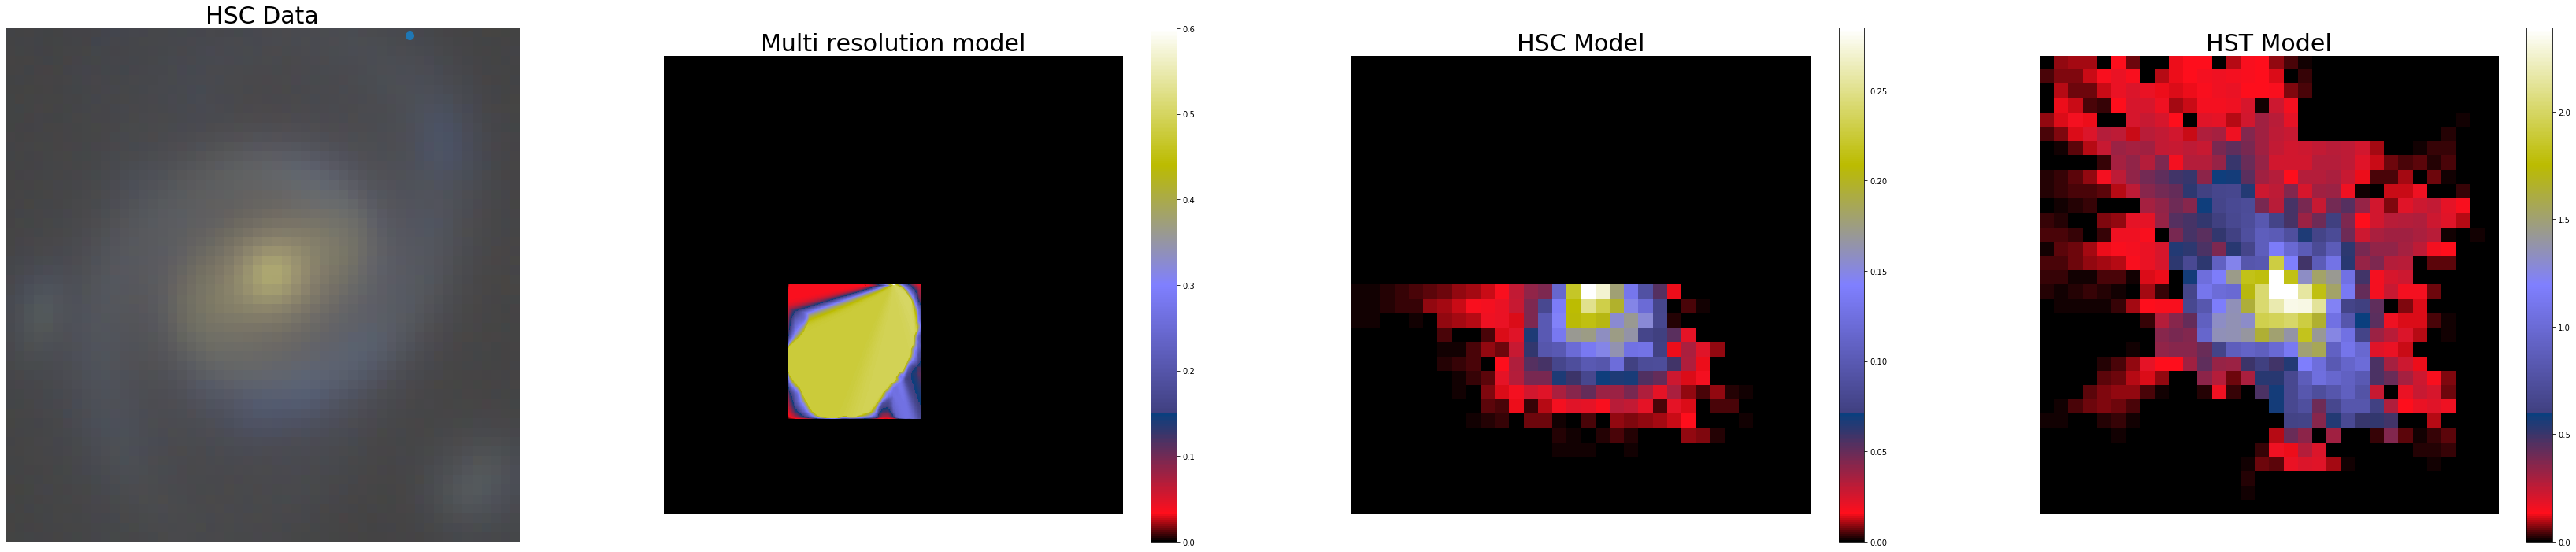

source number  1


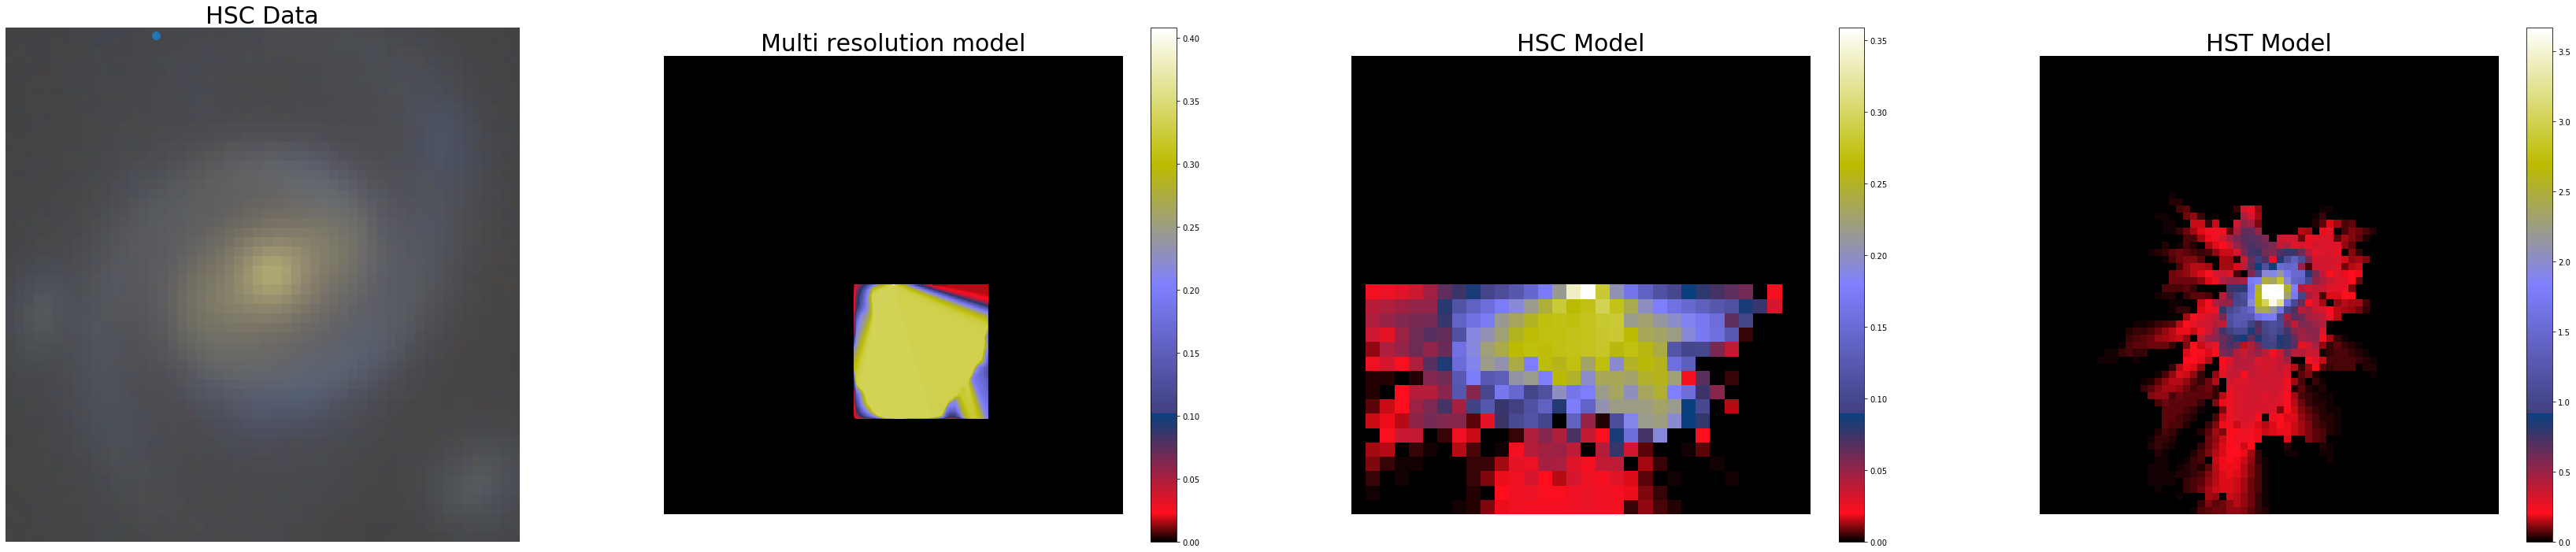

source number  2


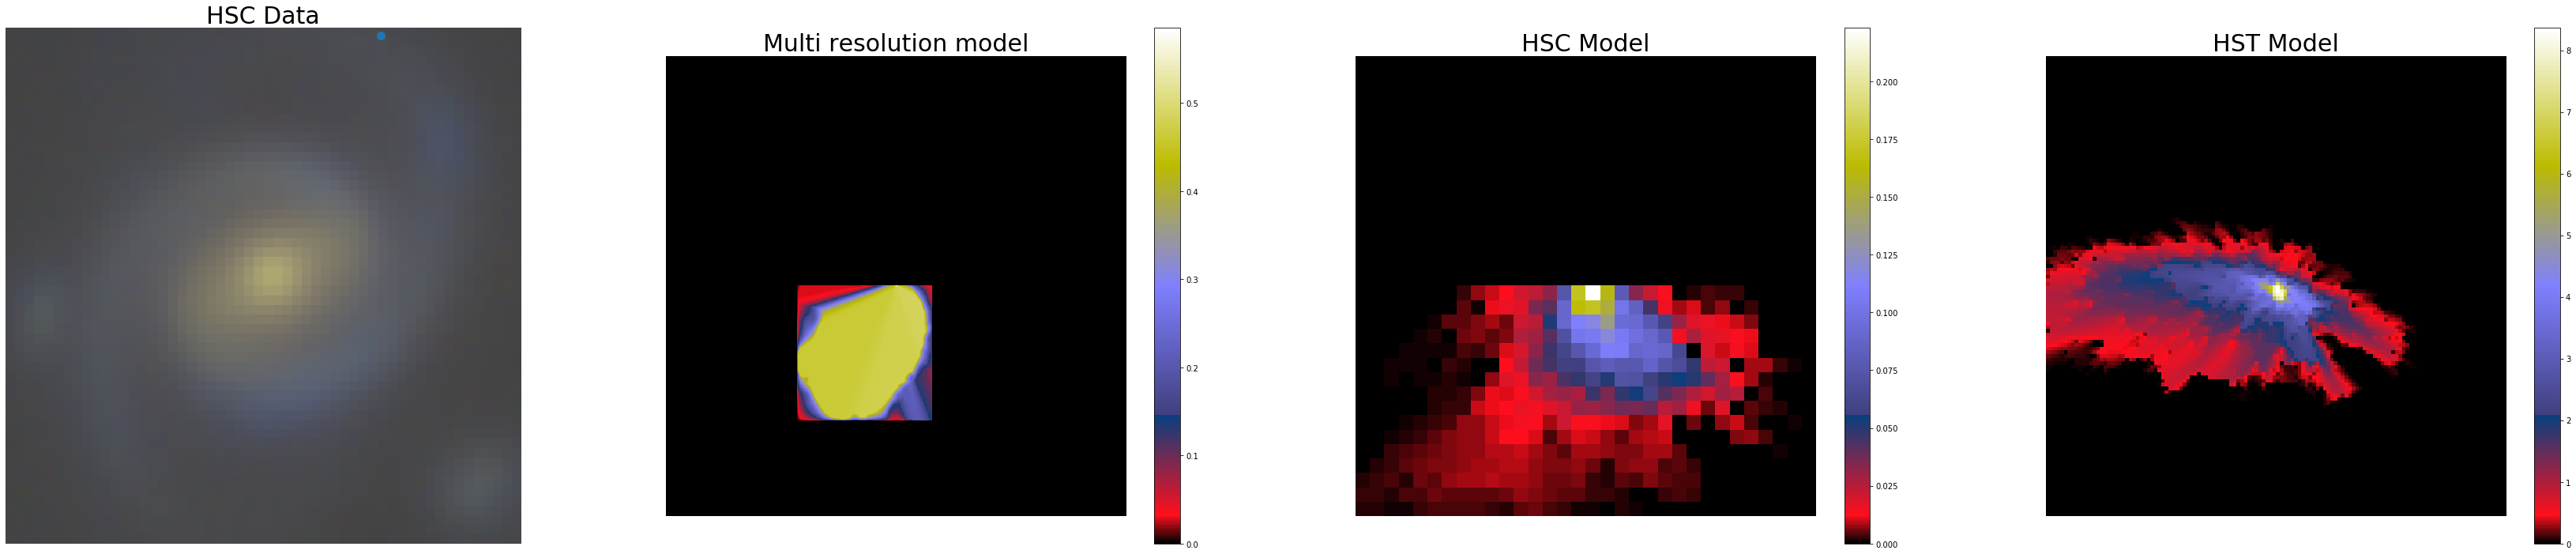

source number  3


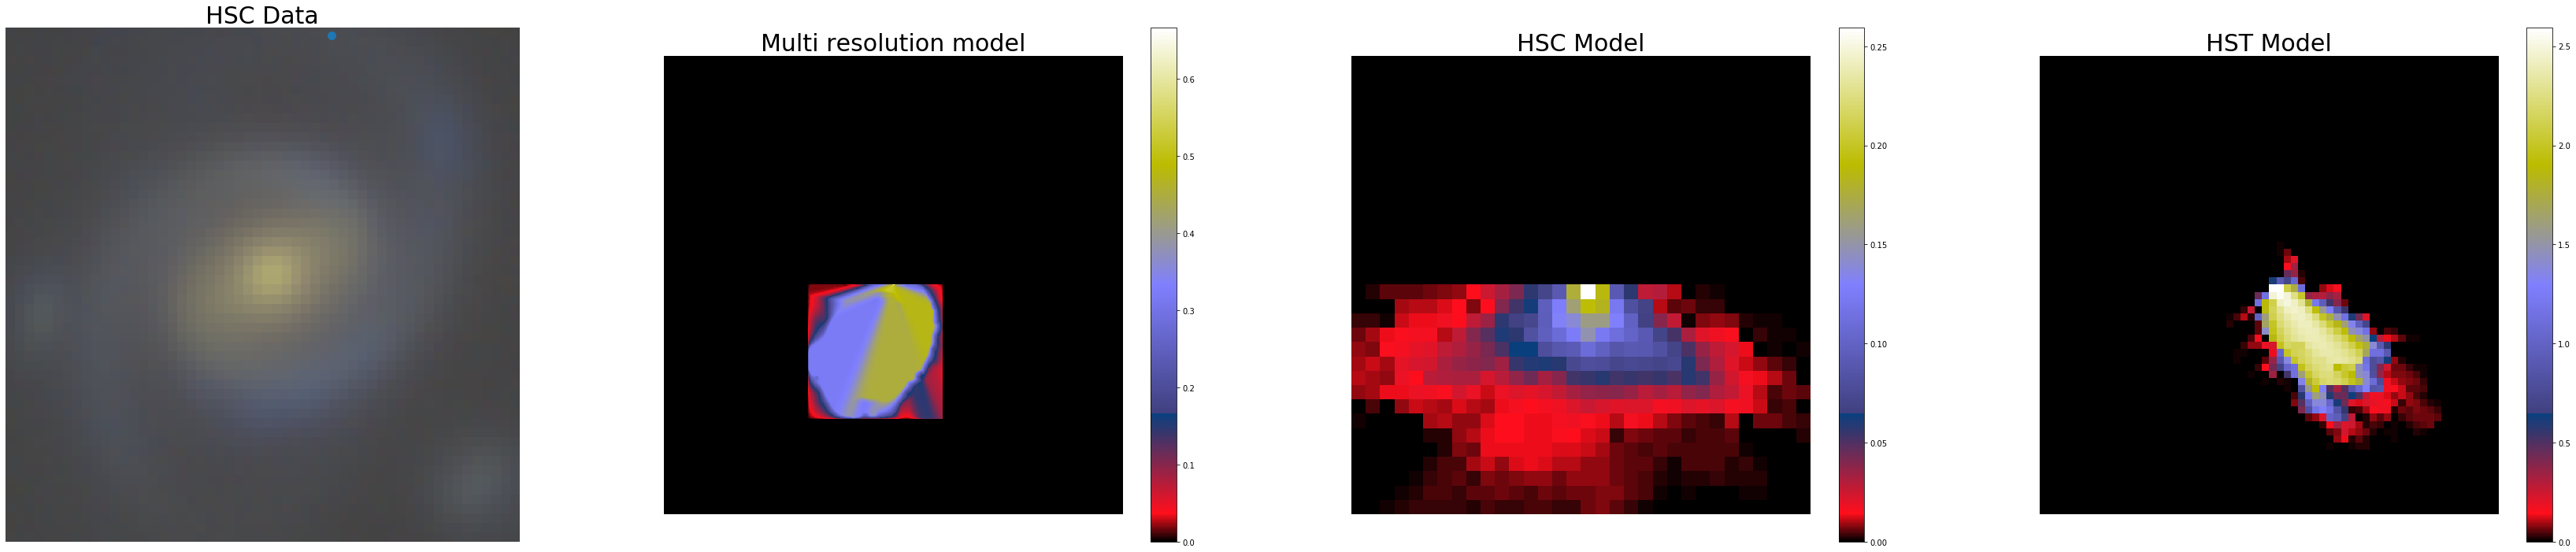

source number  4


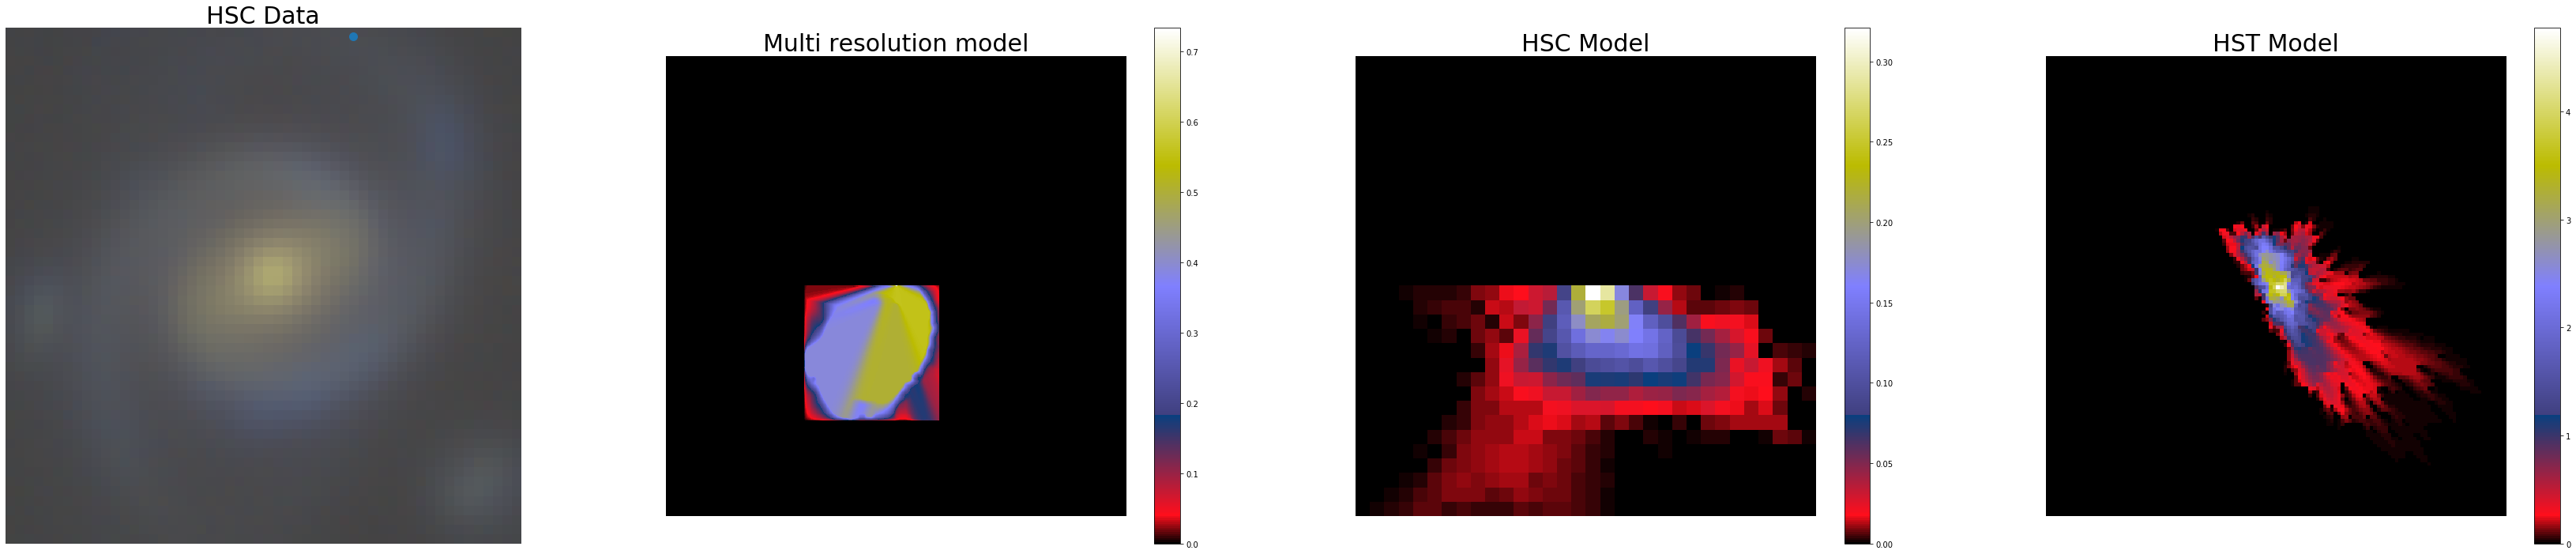

source number  5


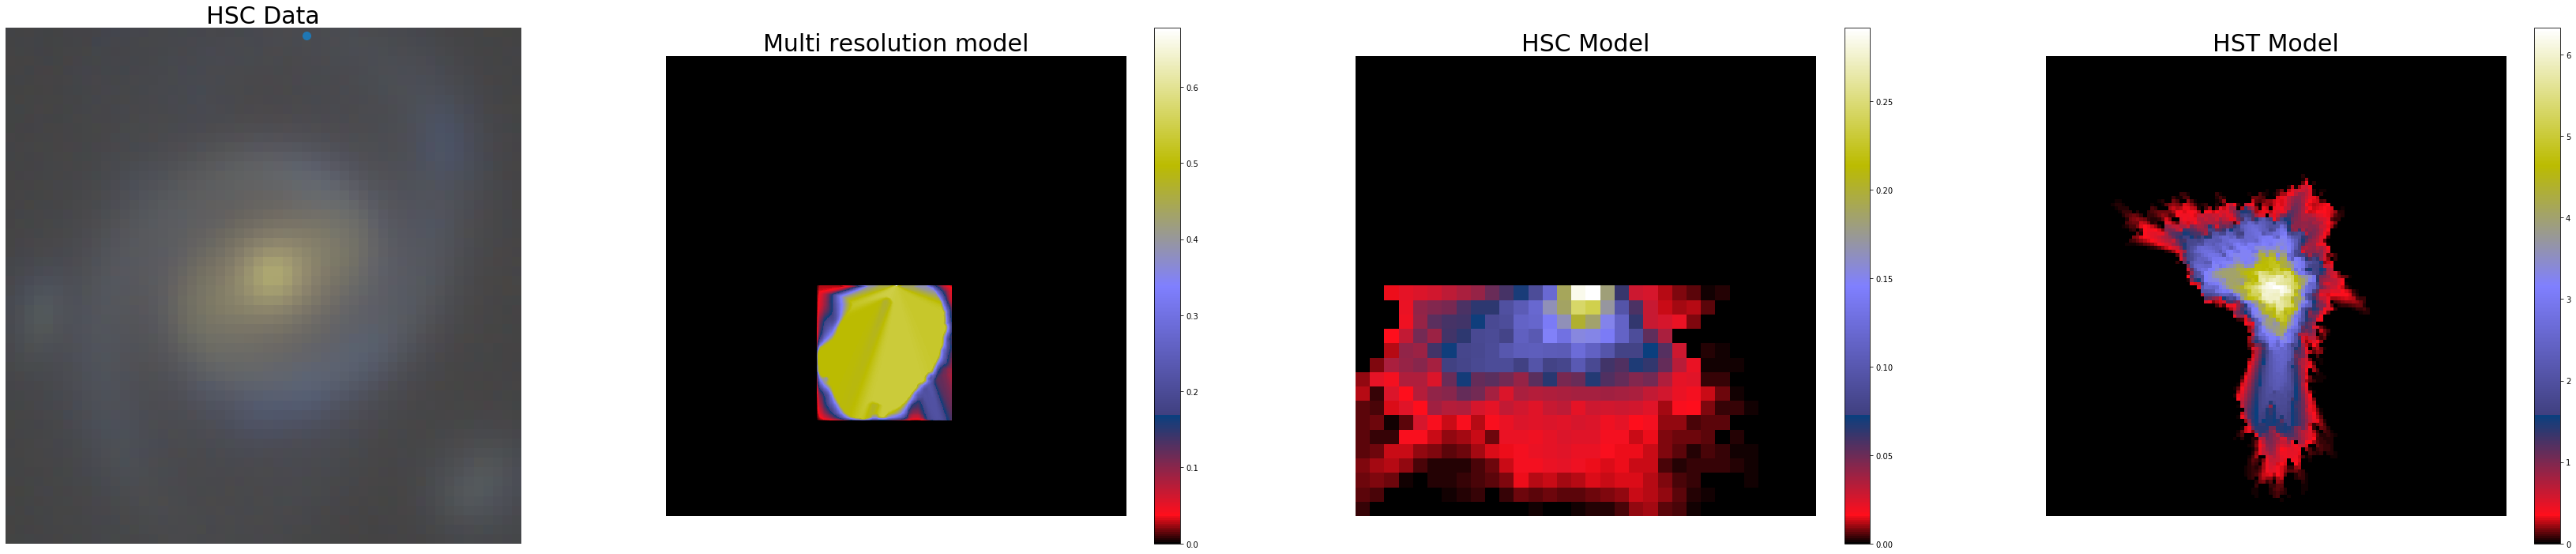

source number  6


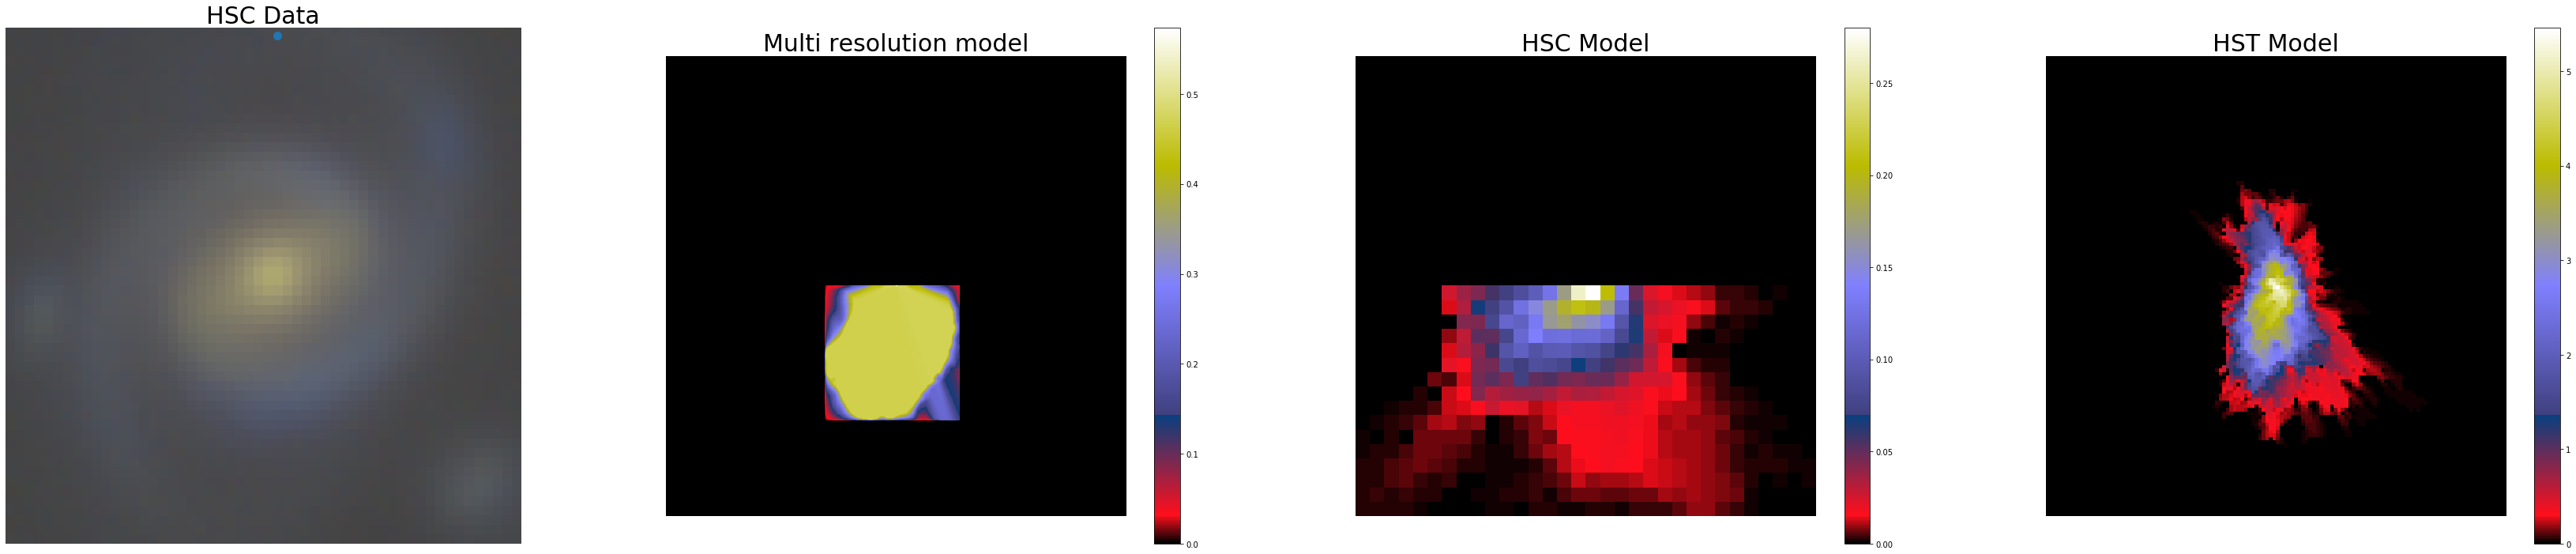

source number  7


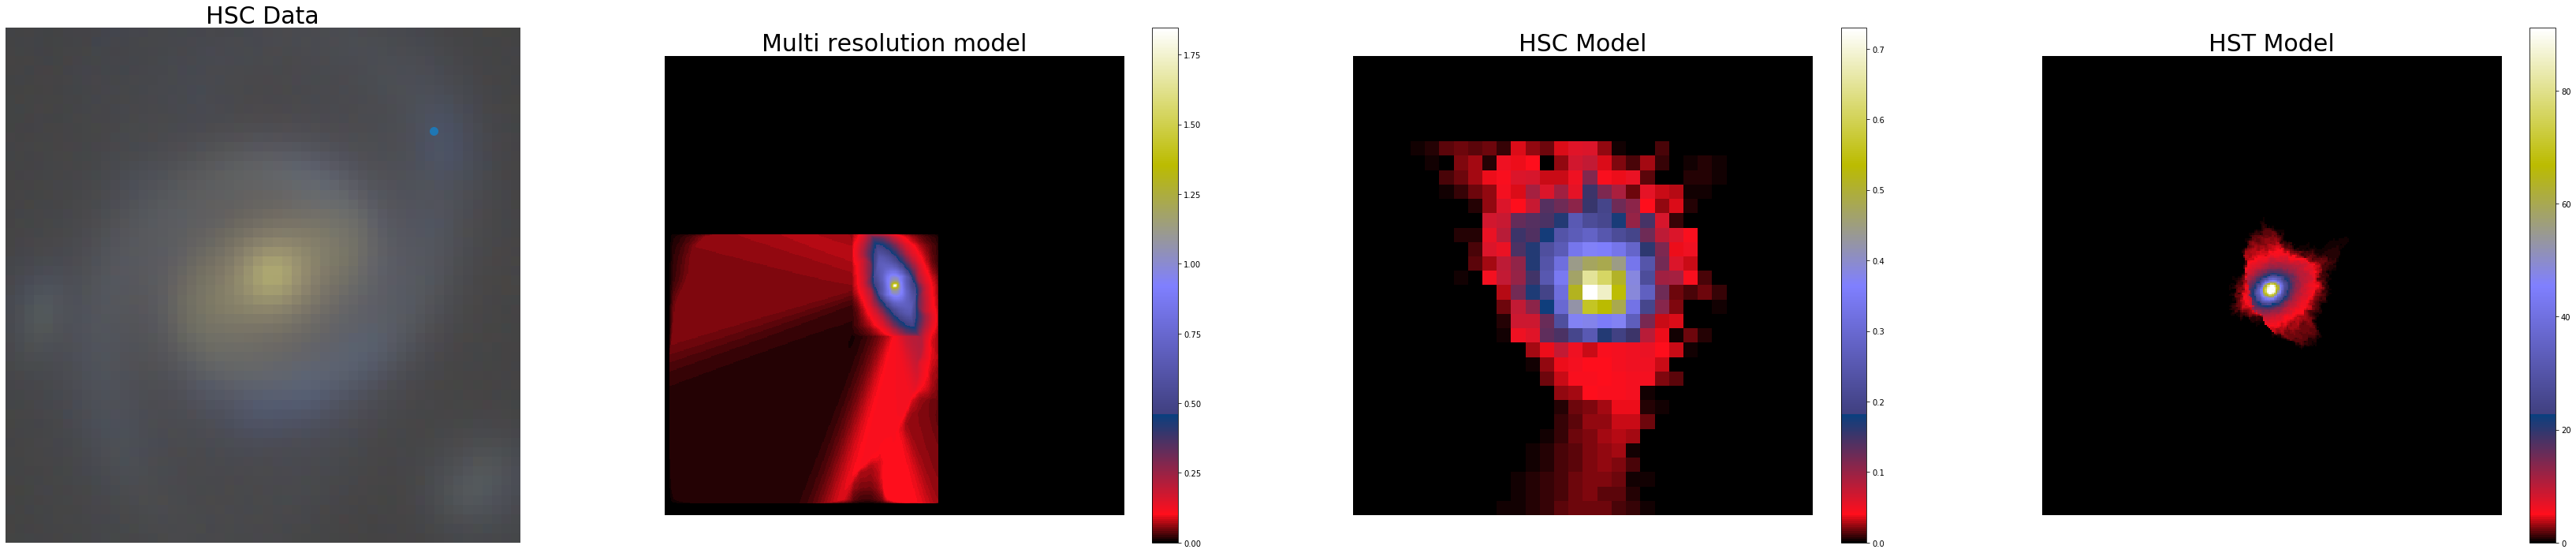

source number  8


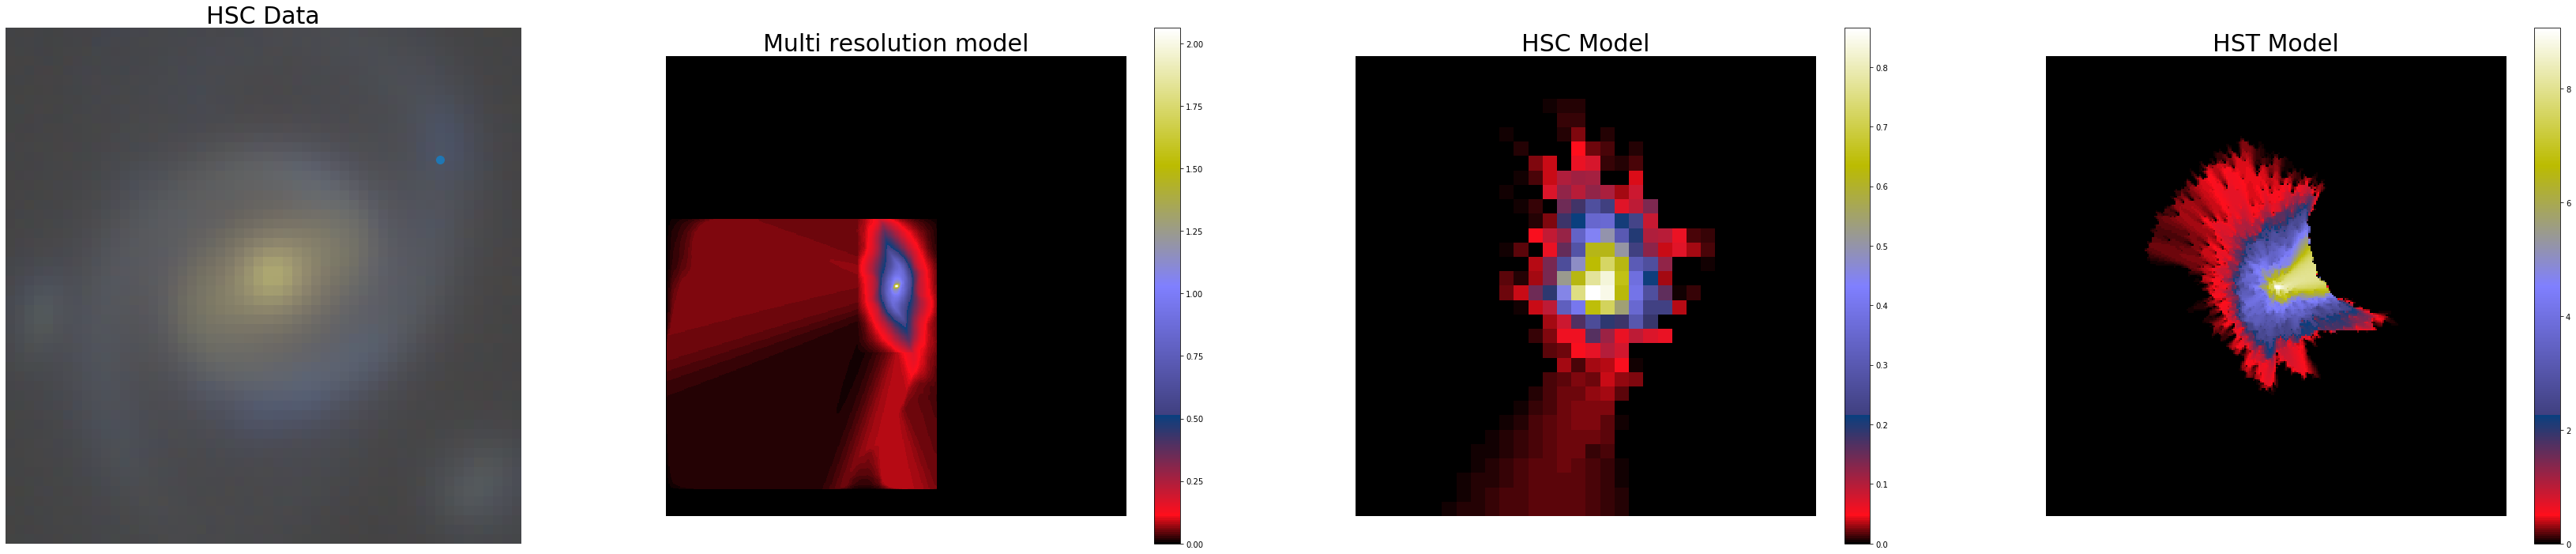

source number  9


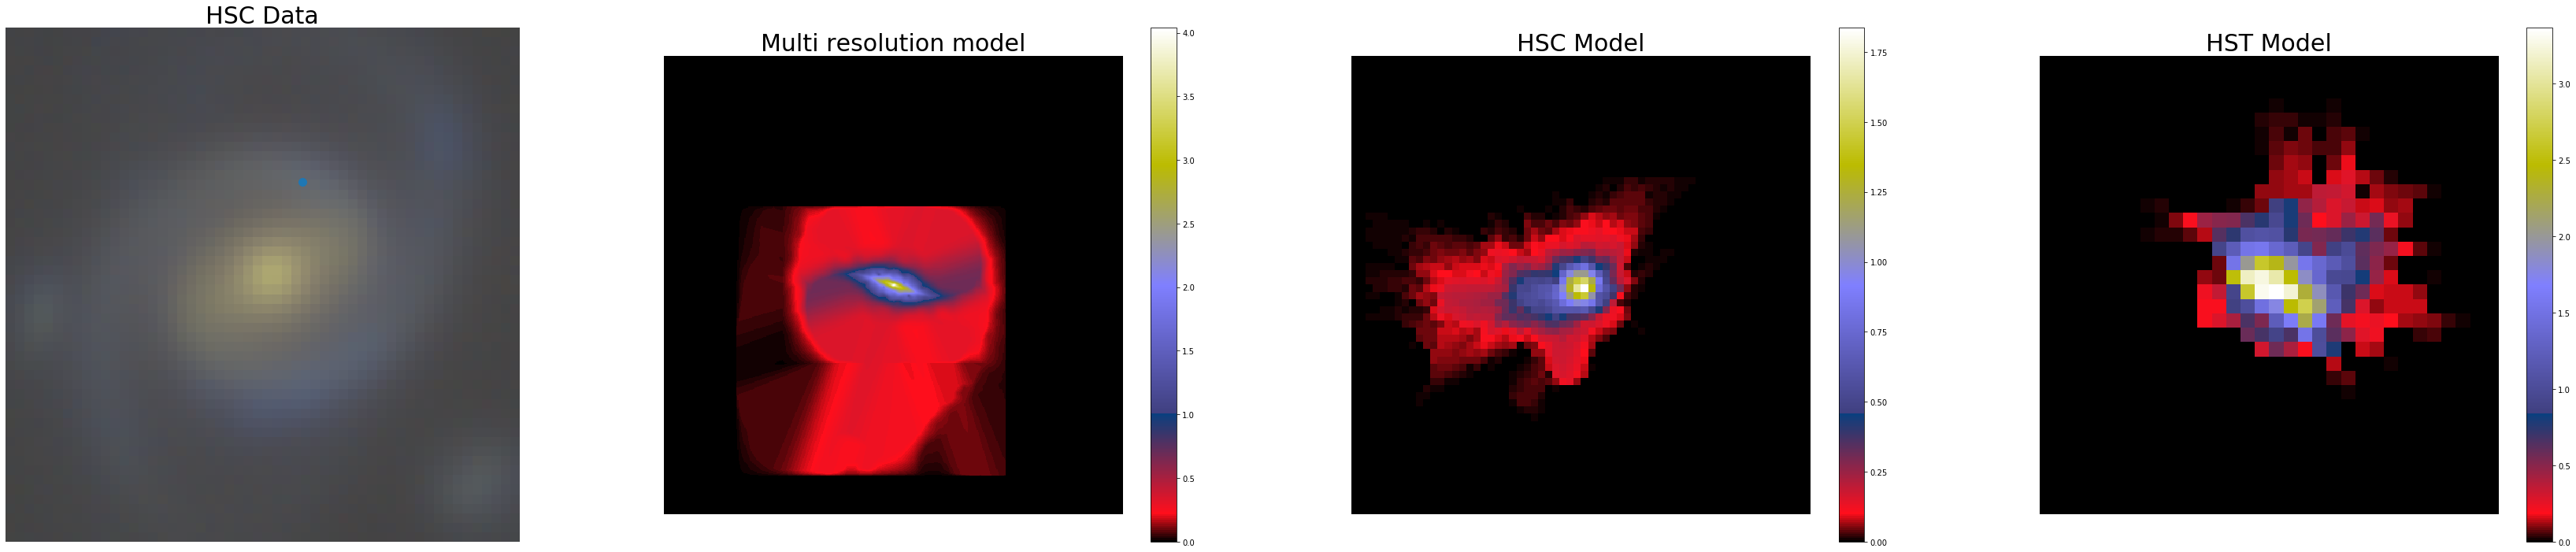

source number  10


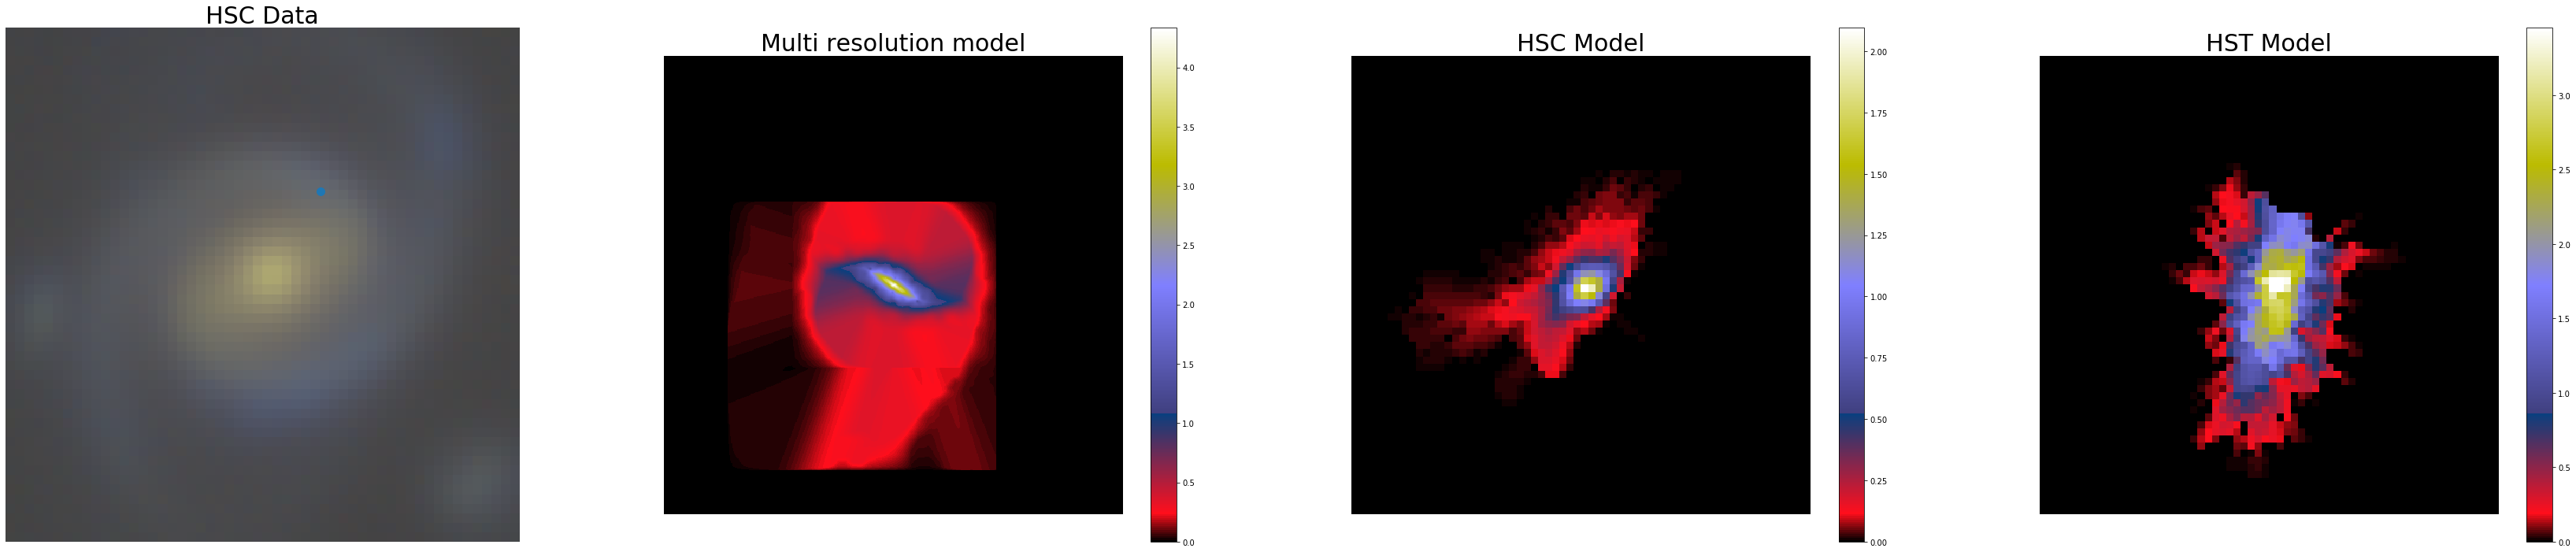

source number  11


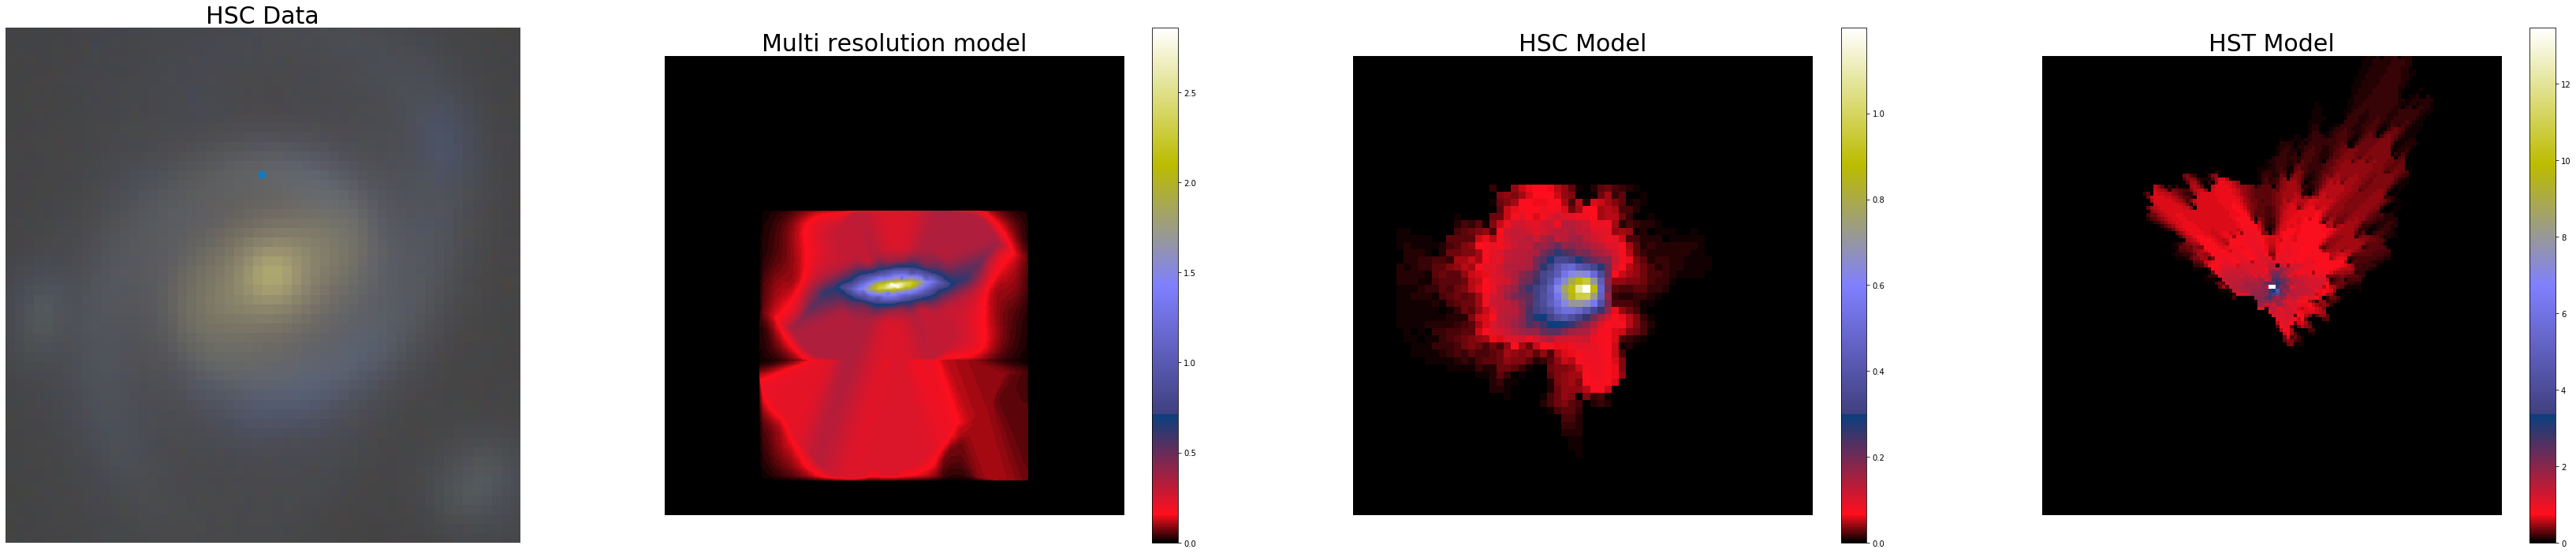

source number  12


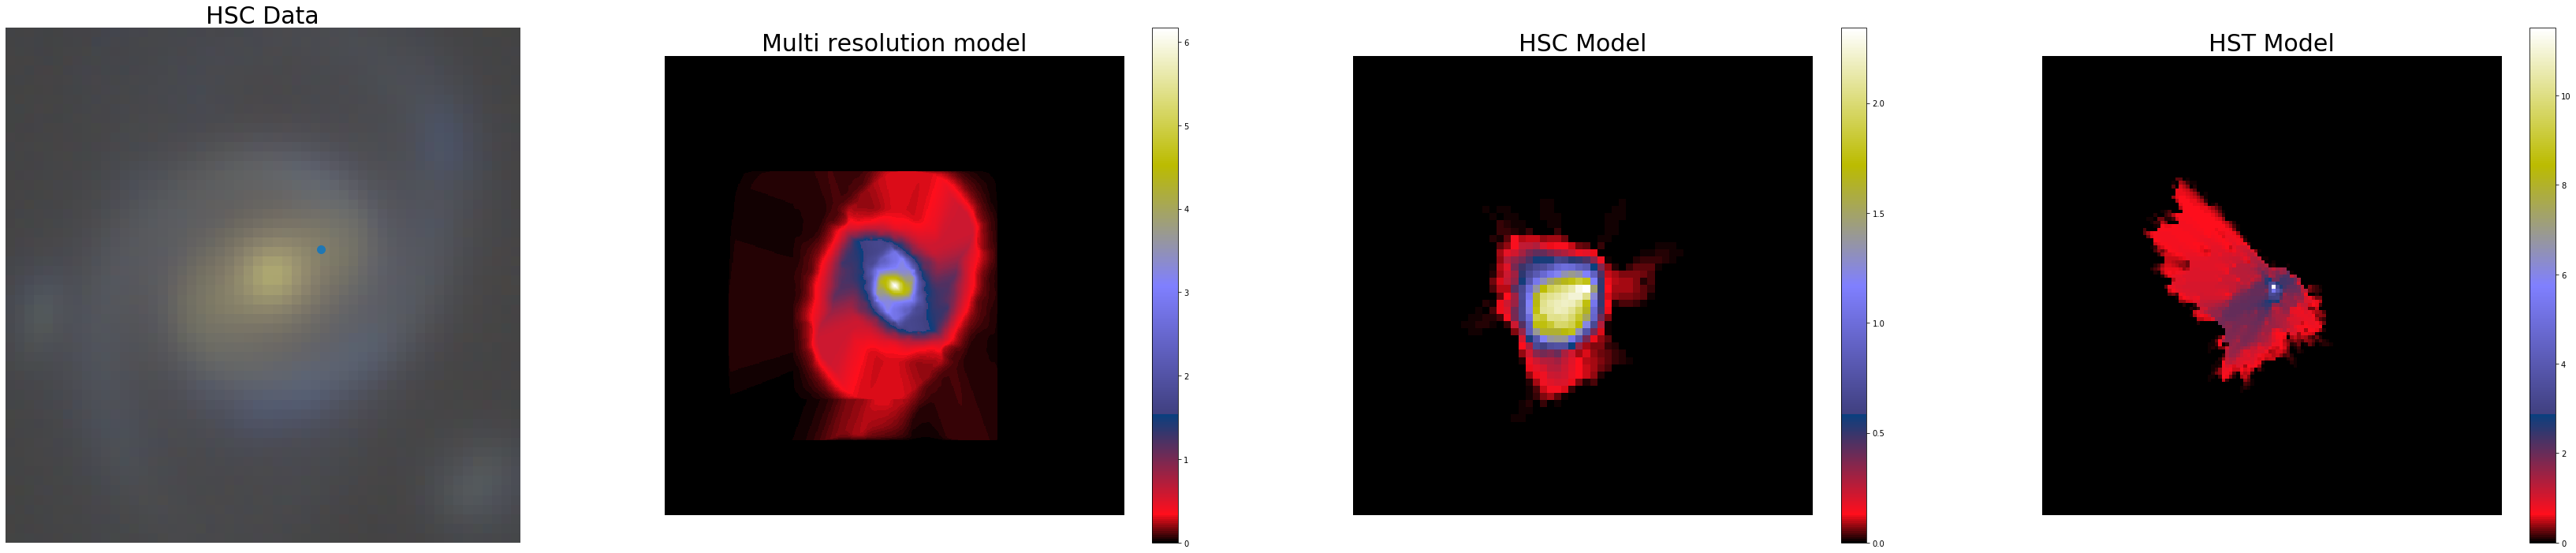

source number  13


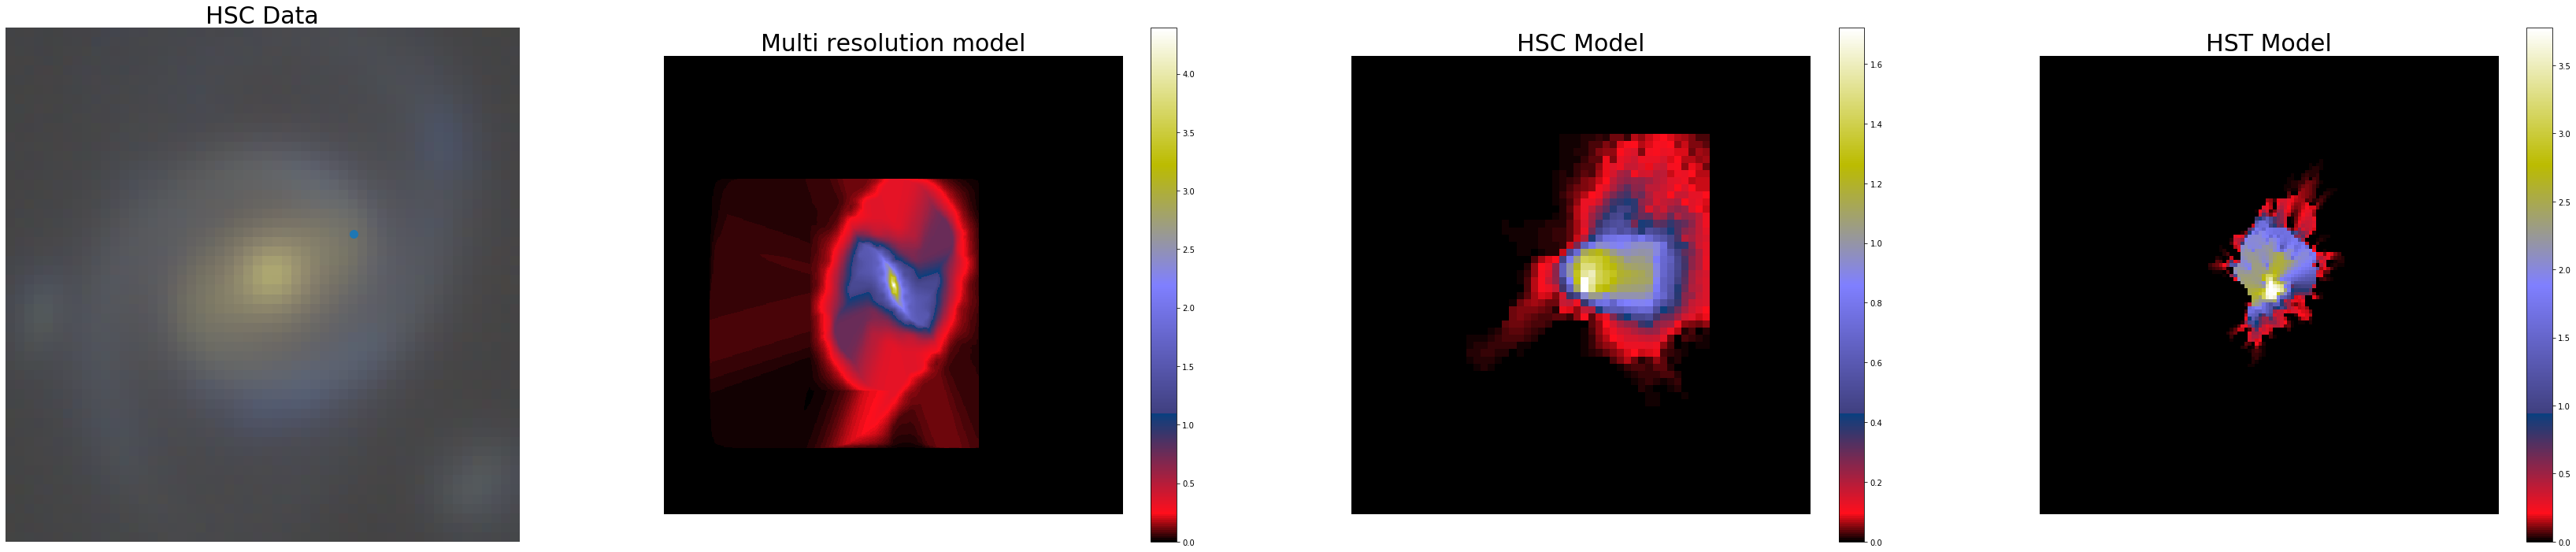

source number  14


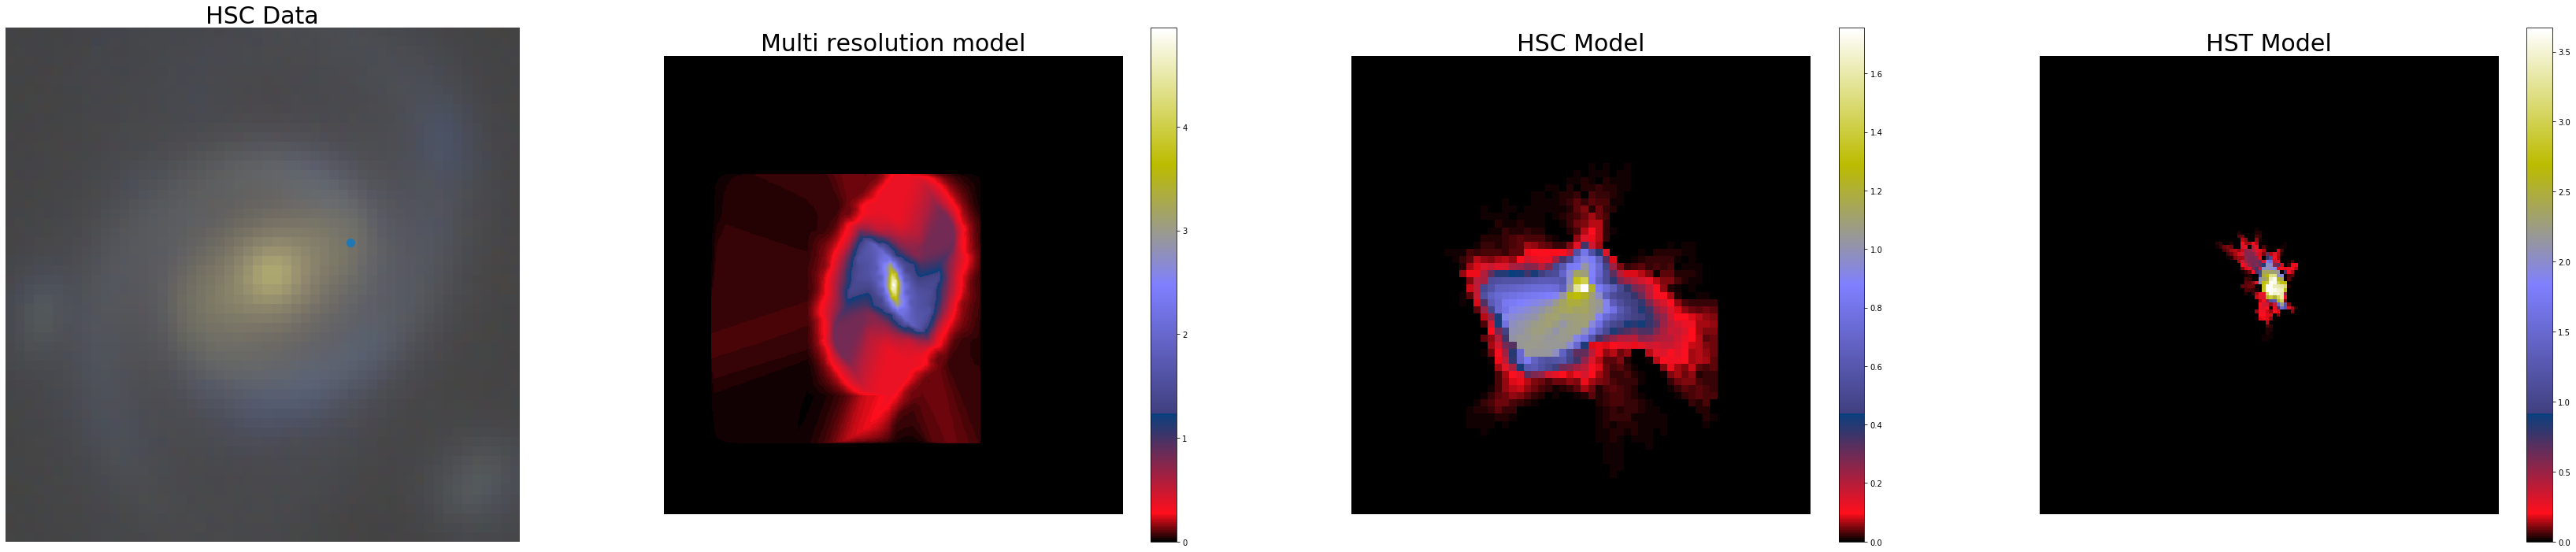

source number  15


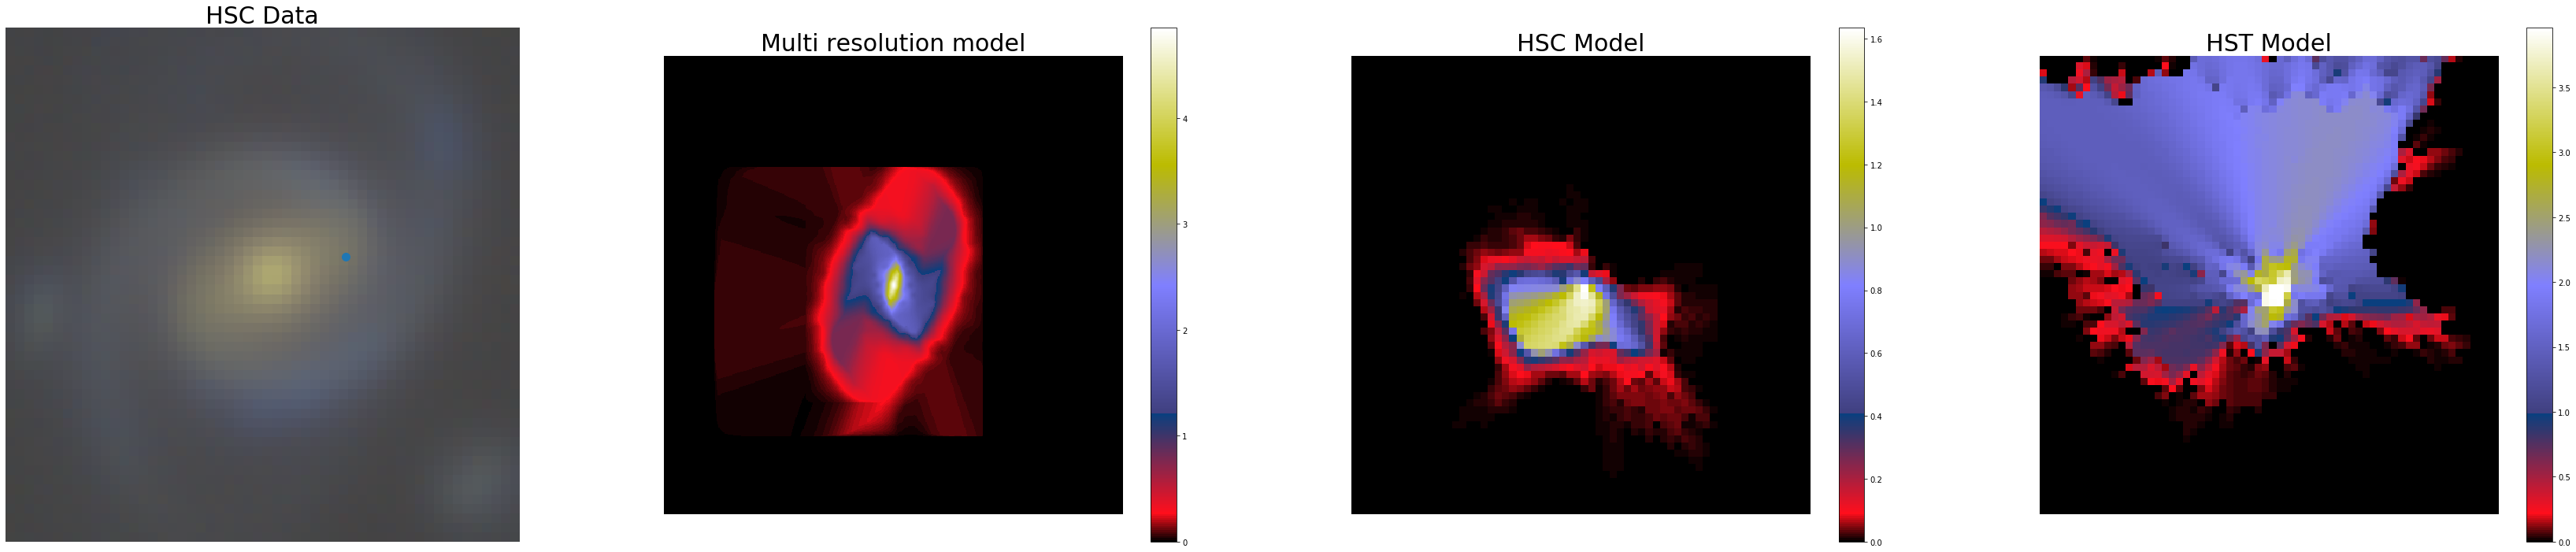

source number  16


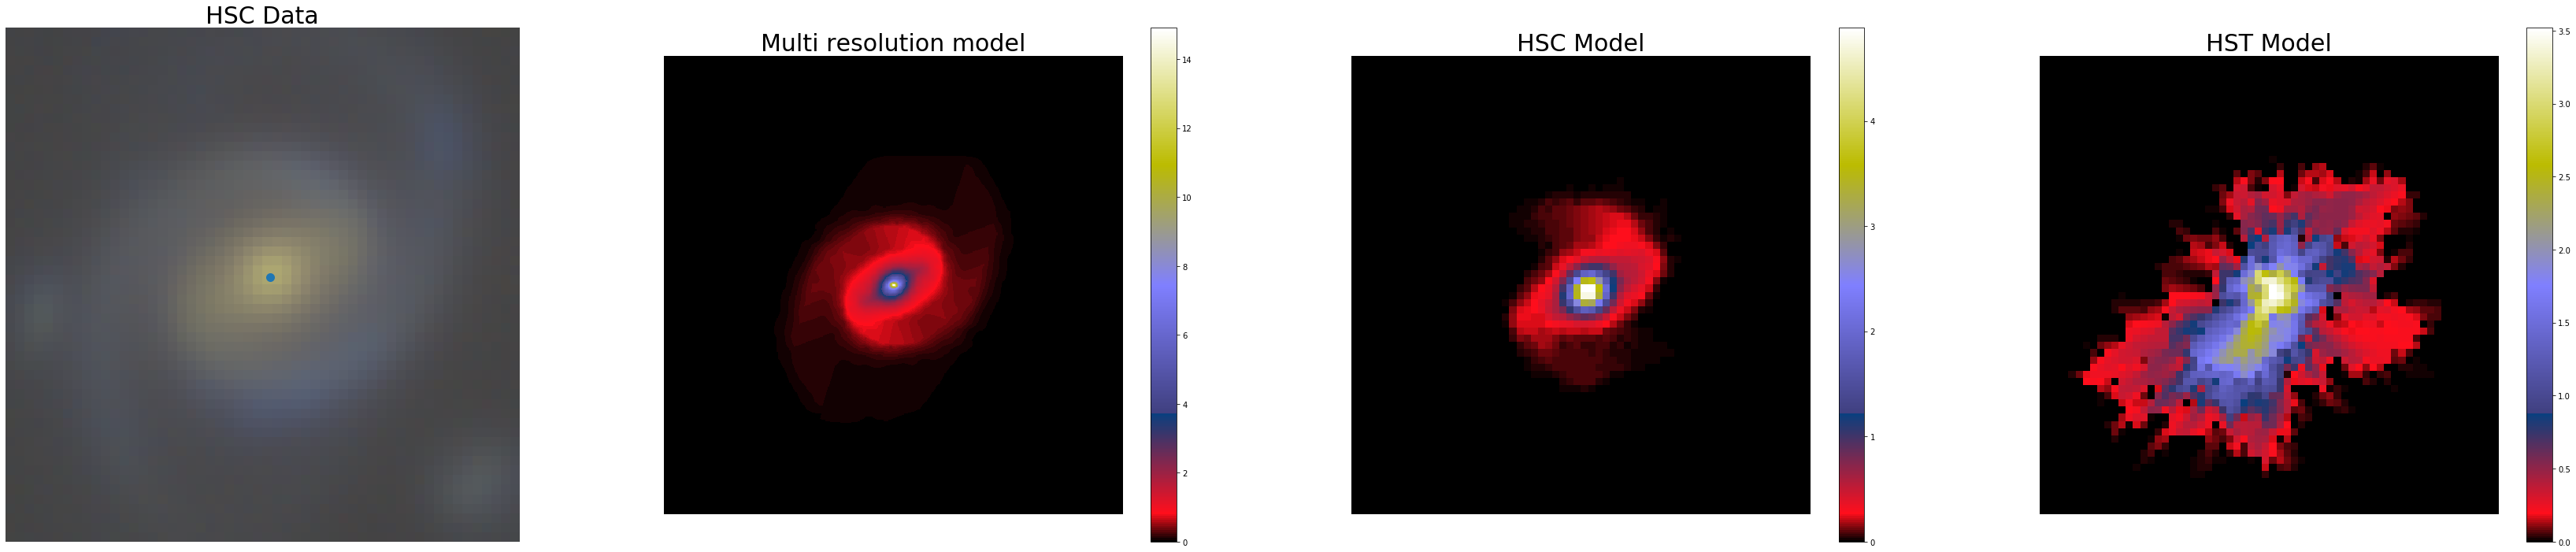

source number  17


IndexError: tuple index out of range

In [47]:
has_truth = False
axes = 2

for k,src in enumerate(blend_multi.sources):
    print('source number ', k)
    # Get the model for a single source
    source_multi = src.get_model()
    source_multihsc = blend_multihsc[k].get_model()
    source_multihst = blend_multihst[k].get_model()
    
    # Display the low resolution image and residuals
    img_lr_rgb = scarlet.display.img_to_rgb(model_lr, norm = hsc_norm)
    
    plt.figure(figsize=(60,12))
    
    plt.subplot(141)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.plot(Xm[k],Ym[k], 'o', markersize = 10)
    plt.title("HSC Data", fontsize = 30)
    plt.subplot(142)
    plt.imshow(source_multi[0])
    plt.axis('off')
    plt.colorbar()
    plt.title("Multi resolution model", fontsize = 30)
    plt.subplot(143)
    plt.imshow(source_multihsc[0])
    plt.axis('off')
    plt.colorbar()
    plt.title("HSC Model", fontsize = 30)
    plt.subplot(144)
    plt.imshow(source_multihst[-1])
    plt.axis('off')
    plt.colorbar()
    plt.title("HST Model", fontsize = 30)
    plt.show()

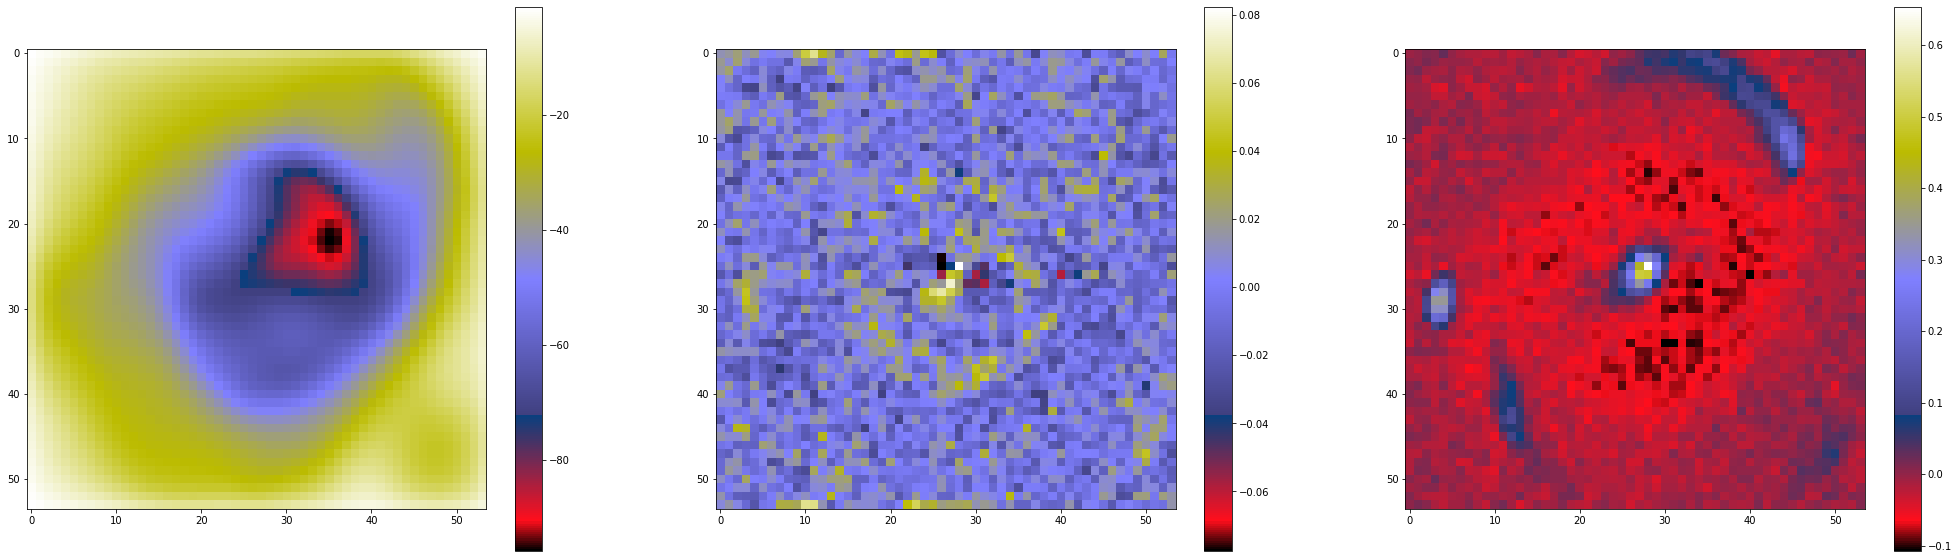

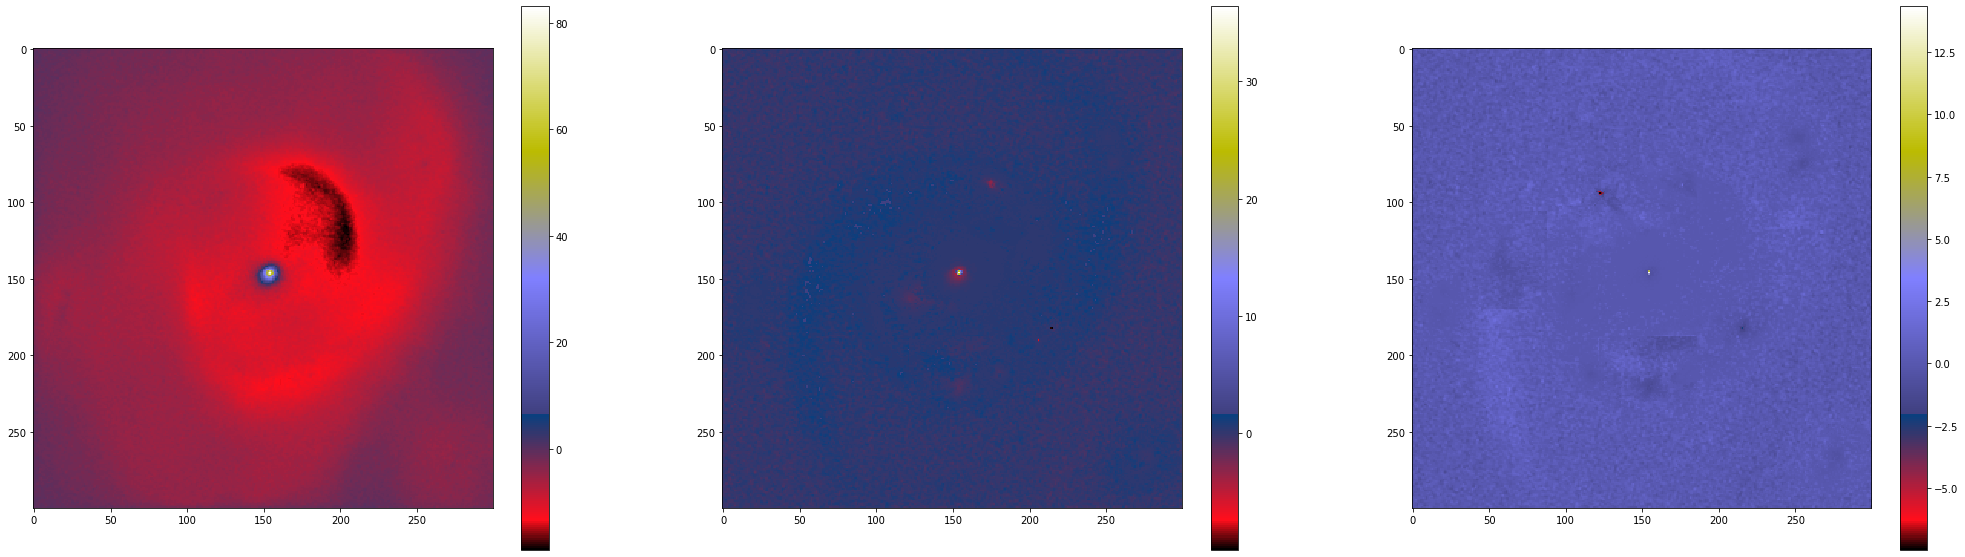

In [45]:
# Results:
model_multi = blend_multi.get_model()
render_hrm = multi_hst.render(model_multi)
render_lrm = multi_hsc.render(model_multi)

model_hsc = blend_hsc.get_model()
render_hsc = obs_hsc.render(model_hsc)

model_hst = blend_hst.get_model()
render_hst = obs_hst.render(model_hst)

model_hscmulti = blend_multihsc.get_model()
render_hscmulti = obs_hsc.render(model_hscmulti)

model_hstmulti = blend_multihst.get_model()
render_hstmulti = obs_hst.render(model_hstmulti)

# RGB images of the residuals
plt.figure(figsize = (35,10))
plt.subplot(131)
plt.imshow((data_hsc - render_lrm)[2])
plt.colorbar()
plt.subplot(132)
plt.imshow((data_hsc - render_hscmulti)[2])
plt.colorbar()
plt.subplot(133)
plt.imshow((data_hsc - render_hsc)[2])
plt.colorbar()
plt.show()

# RGB images of the residuals
plt.figure(figsize = (35,10))
plt.subplot(131)
plt.imshow((data_hst - render_hrm)[0])
plt.colorbar()
plt.subplot(132)
plt.imshow((data_hst - render_hstmulti)[0])
plt.colorbar()
plt.subplot(133)
plt.imshow((data_hst - render_hst)[0])
plt.colorbar()
plt.show()




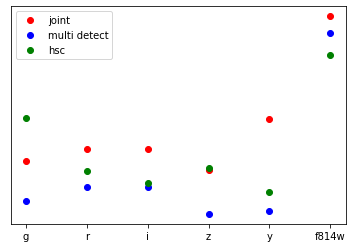

In [25]:
# HSC residuals
chi_joint = (np.sum((data_hsc - render_lrm)**2, axis = (-2,-1))/mad_wavelet(data_hsc)**2)**0.5
chi_multi = (np.sum((data_hsc - render_hscmulti)**2, axis = (-2,-1))/mad_wavelet(data_hsc)**2)**0.5
chi_alone = (np.sum((data_hsc - render_hsc)**2, axis = (-2,-1))/mad_wavelet(data_hsc)**2)**0.5

chi_hr = np.sum((data_hst - render_hrm)[0]**2/mad_wavelet(data_hst)**2)**0.5
chi_hstmulti = np.sum((data_hst - render_hstmulti)**2/mad_wavelet(data_hst)**2)**0.5
chi_hst = np.sum((data_hst - render_hst)**2/mad_wavelet(data_hst)**2)**0.5

plt.plot(['g','r','i','z','y'], chi_joint, 'or', label = 'joint')
plt.plot(['f814w'], chi_hr, 'or')
plt.plot(['g','r','i','z','y'], chi_multi, 'ob', label = 'multi detect')
plt.plot(['f814w'], chi_hstmulti, 'ob')
plt.plot(['g','r','i','z','y'], chi_alone, 'og', label = 'hsc')
plt.plot(['f814w'], chi_hst, 'og')
plt.yscale('symlog')
plt.legend()
plt.show()
# HST residuals

